# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import RIS_gravity_inversion.plotting as RIS_plotting
import pygmt
from tqdm.autonotebook import tqdm

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km
INFO:root:returning grid with new region and/or registration, same spacing


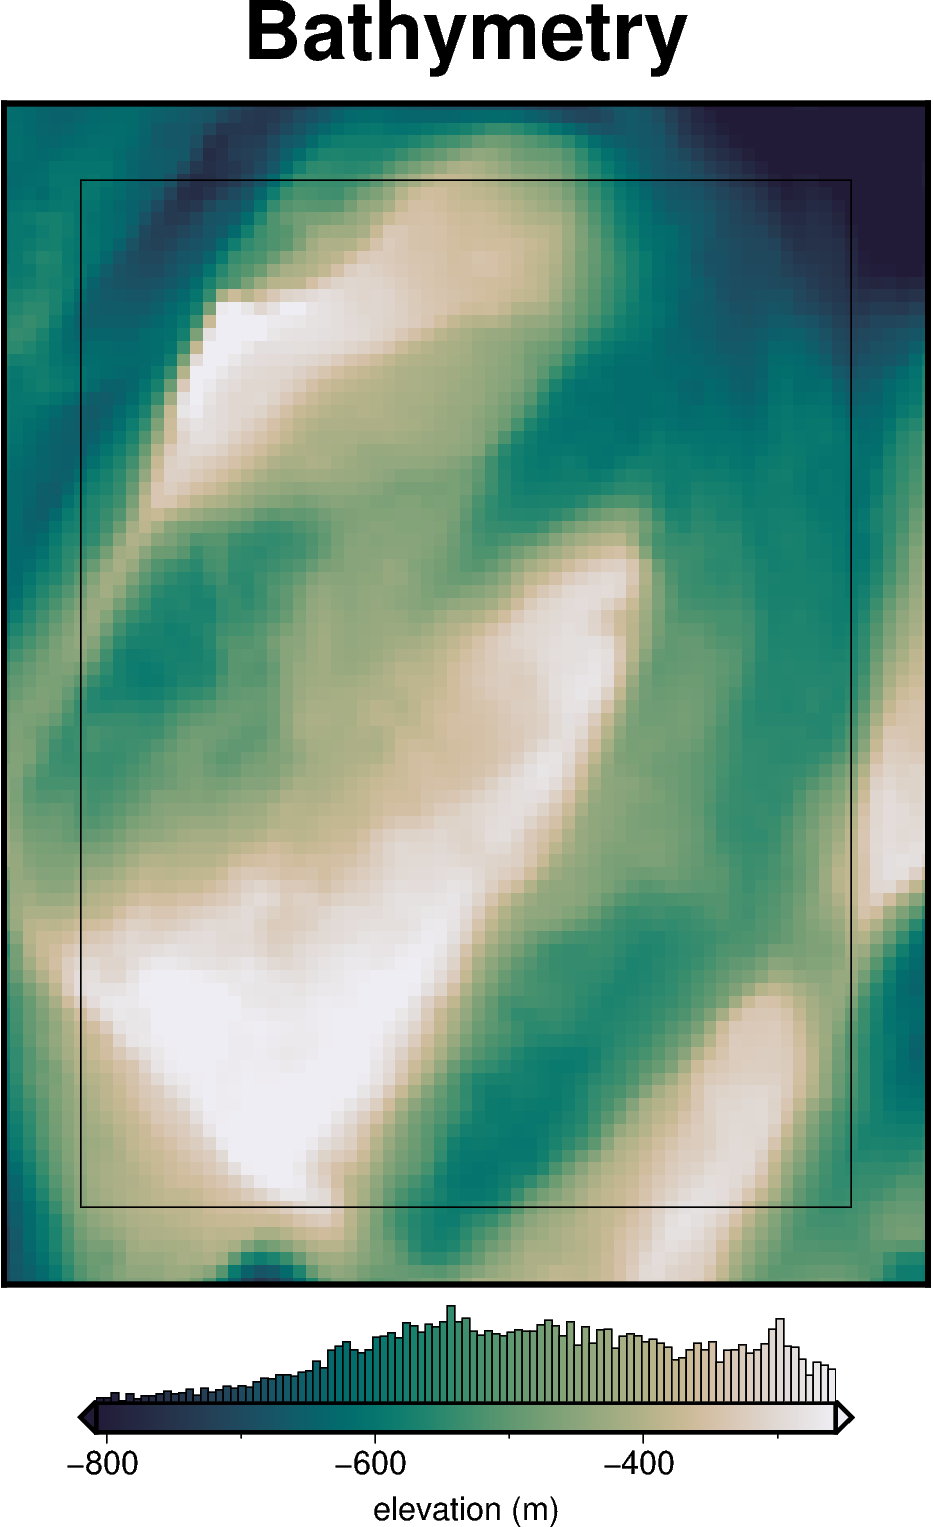

  0%|          | 0/4941 [00:00<?, ?it/s]

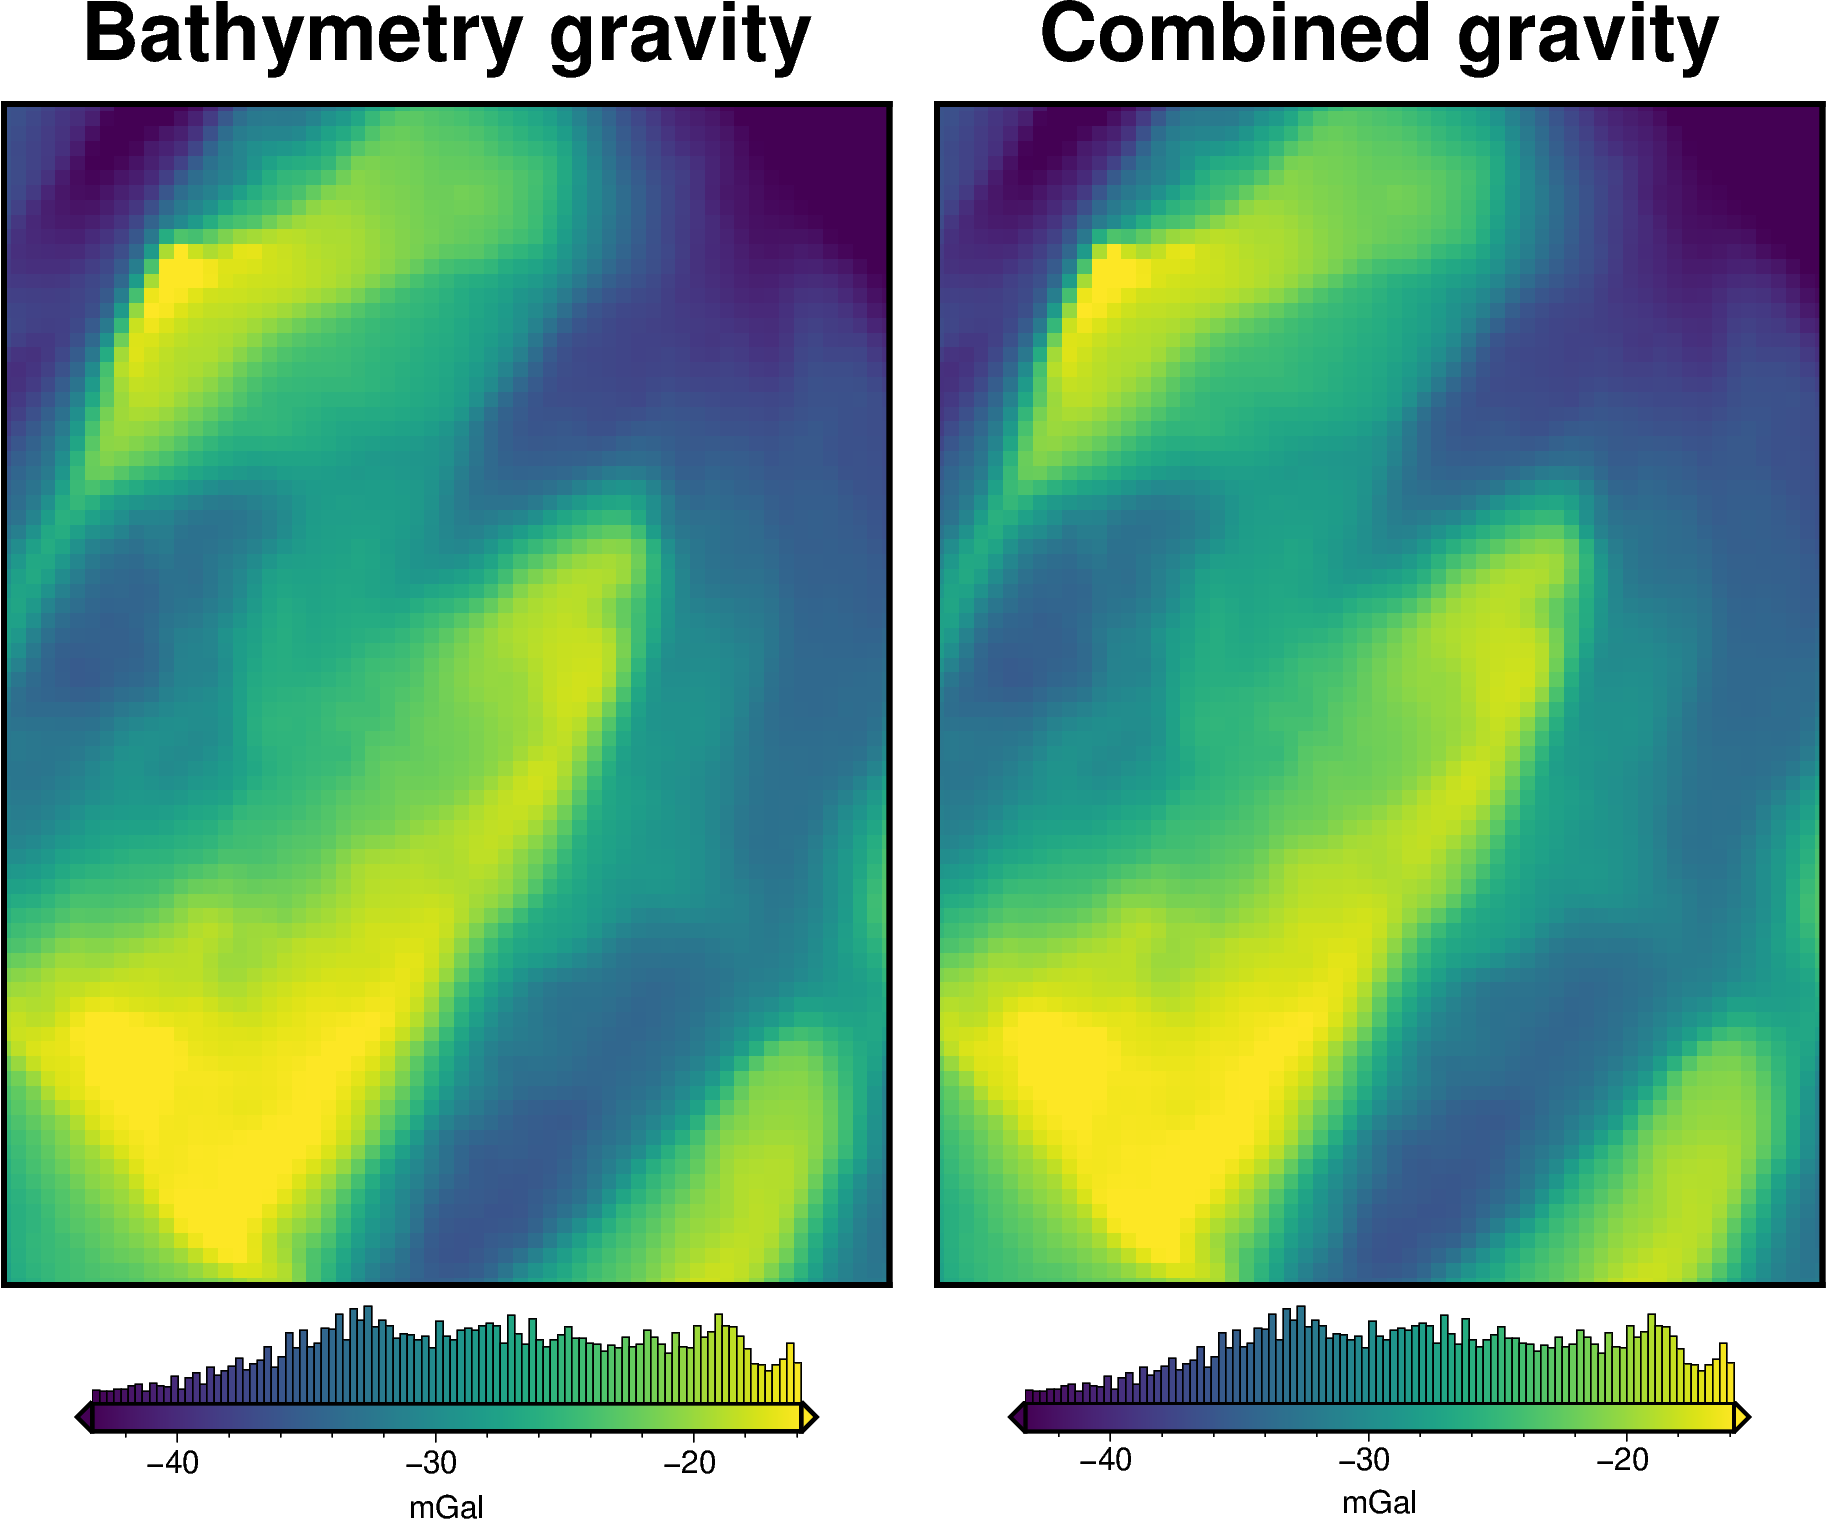

In [ ]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

true_density_contrast = 1476

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing*6,
    # gravity_noise=0,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

# rename no-noise grav column
grav_df=grav_df.rename(columns={"gravity_anomaly": "gravity_anomaly_no_noise"})

In [3]:
grav_df.describe()

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,uncert,gravity_anomaly_no_noise
count,4.941000e+03,4941.00000,4941.0,4941.000000,4941.0,4941.000000,4941.0,4941.000000
mean,-1.600000e+06,110000.00000,1000.0,-28.076339,0.0,-28.076339,0.0,-28.076339
std,1.169164e+05,88042.99419,0.0,7.267542,0.0,7.267542,0.0,7.267542
min,-1.800000e+06,-40000.00000,1000.0,-50.834525,0.0,-50.834525,0.0,-50.834525
25%,-1.700000e+06,35000.00000,1000.0,-33.380910,0.0,-33.380910,0.0,-33.380910
50%,-1.600000e+06,110000.00000,1000.0,-28.037682,0.0,-28.037682,0.0,-28.037682
75%,-1.500000e+06,185000.00000,1000.0,-21.983838,0.0,-21.983838,0.0,-21.983838
max,-1.400000e+06,260000.00000,1000.0,-13.088736,0.0,-13.088736,0.0,-13.088736


# Make starting bathymetry model

In [4]:
# make a flat starting model at the mean elevation of the true bathymetry
starting_bathymetry = utils.create_topography(
    method="flat",
    upwards=bathymetry.values.mean(),
    region=buffer_region,
    spacing=spacing,
)
starting_bathymetry

<xarray.DataArray 'upward' (northing: 93, easting: 73)> Size: 54kB
array([[-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       ...,
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631],
       [-484.47796631, -484.47796631, -484.47796631, ..., -484.47796631,
        -484.47796631, -484.47796631]])
Coordinates:
  * easting   (easting) float64 584B -7e+04 -6.5e+04 -6e+04 ... 2.85e+05 2.9e+05
  * northing  (northing) float64 744B -1.83e+06 -1.825e+06 ... -1.37e+06

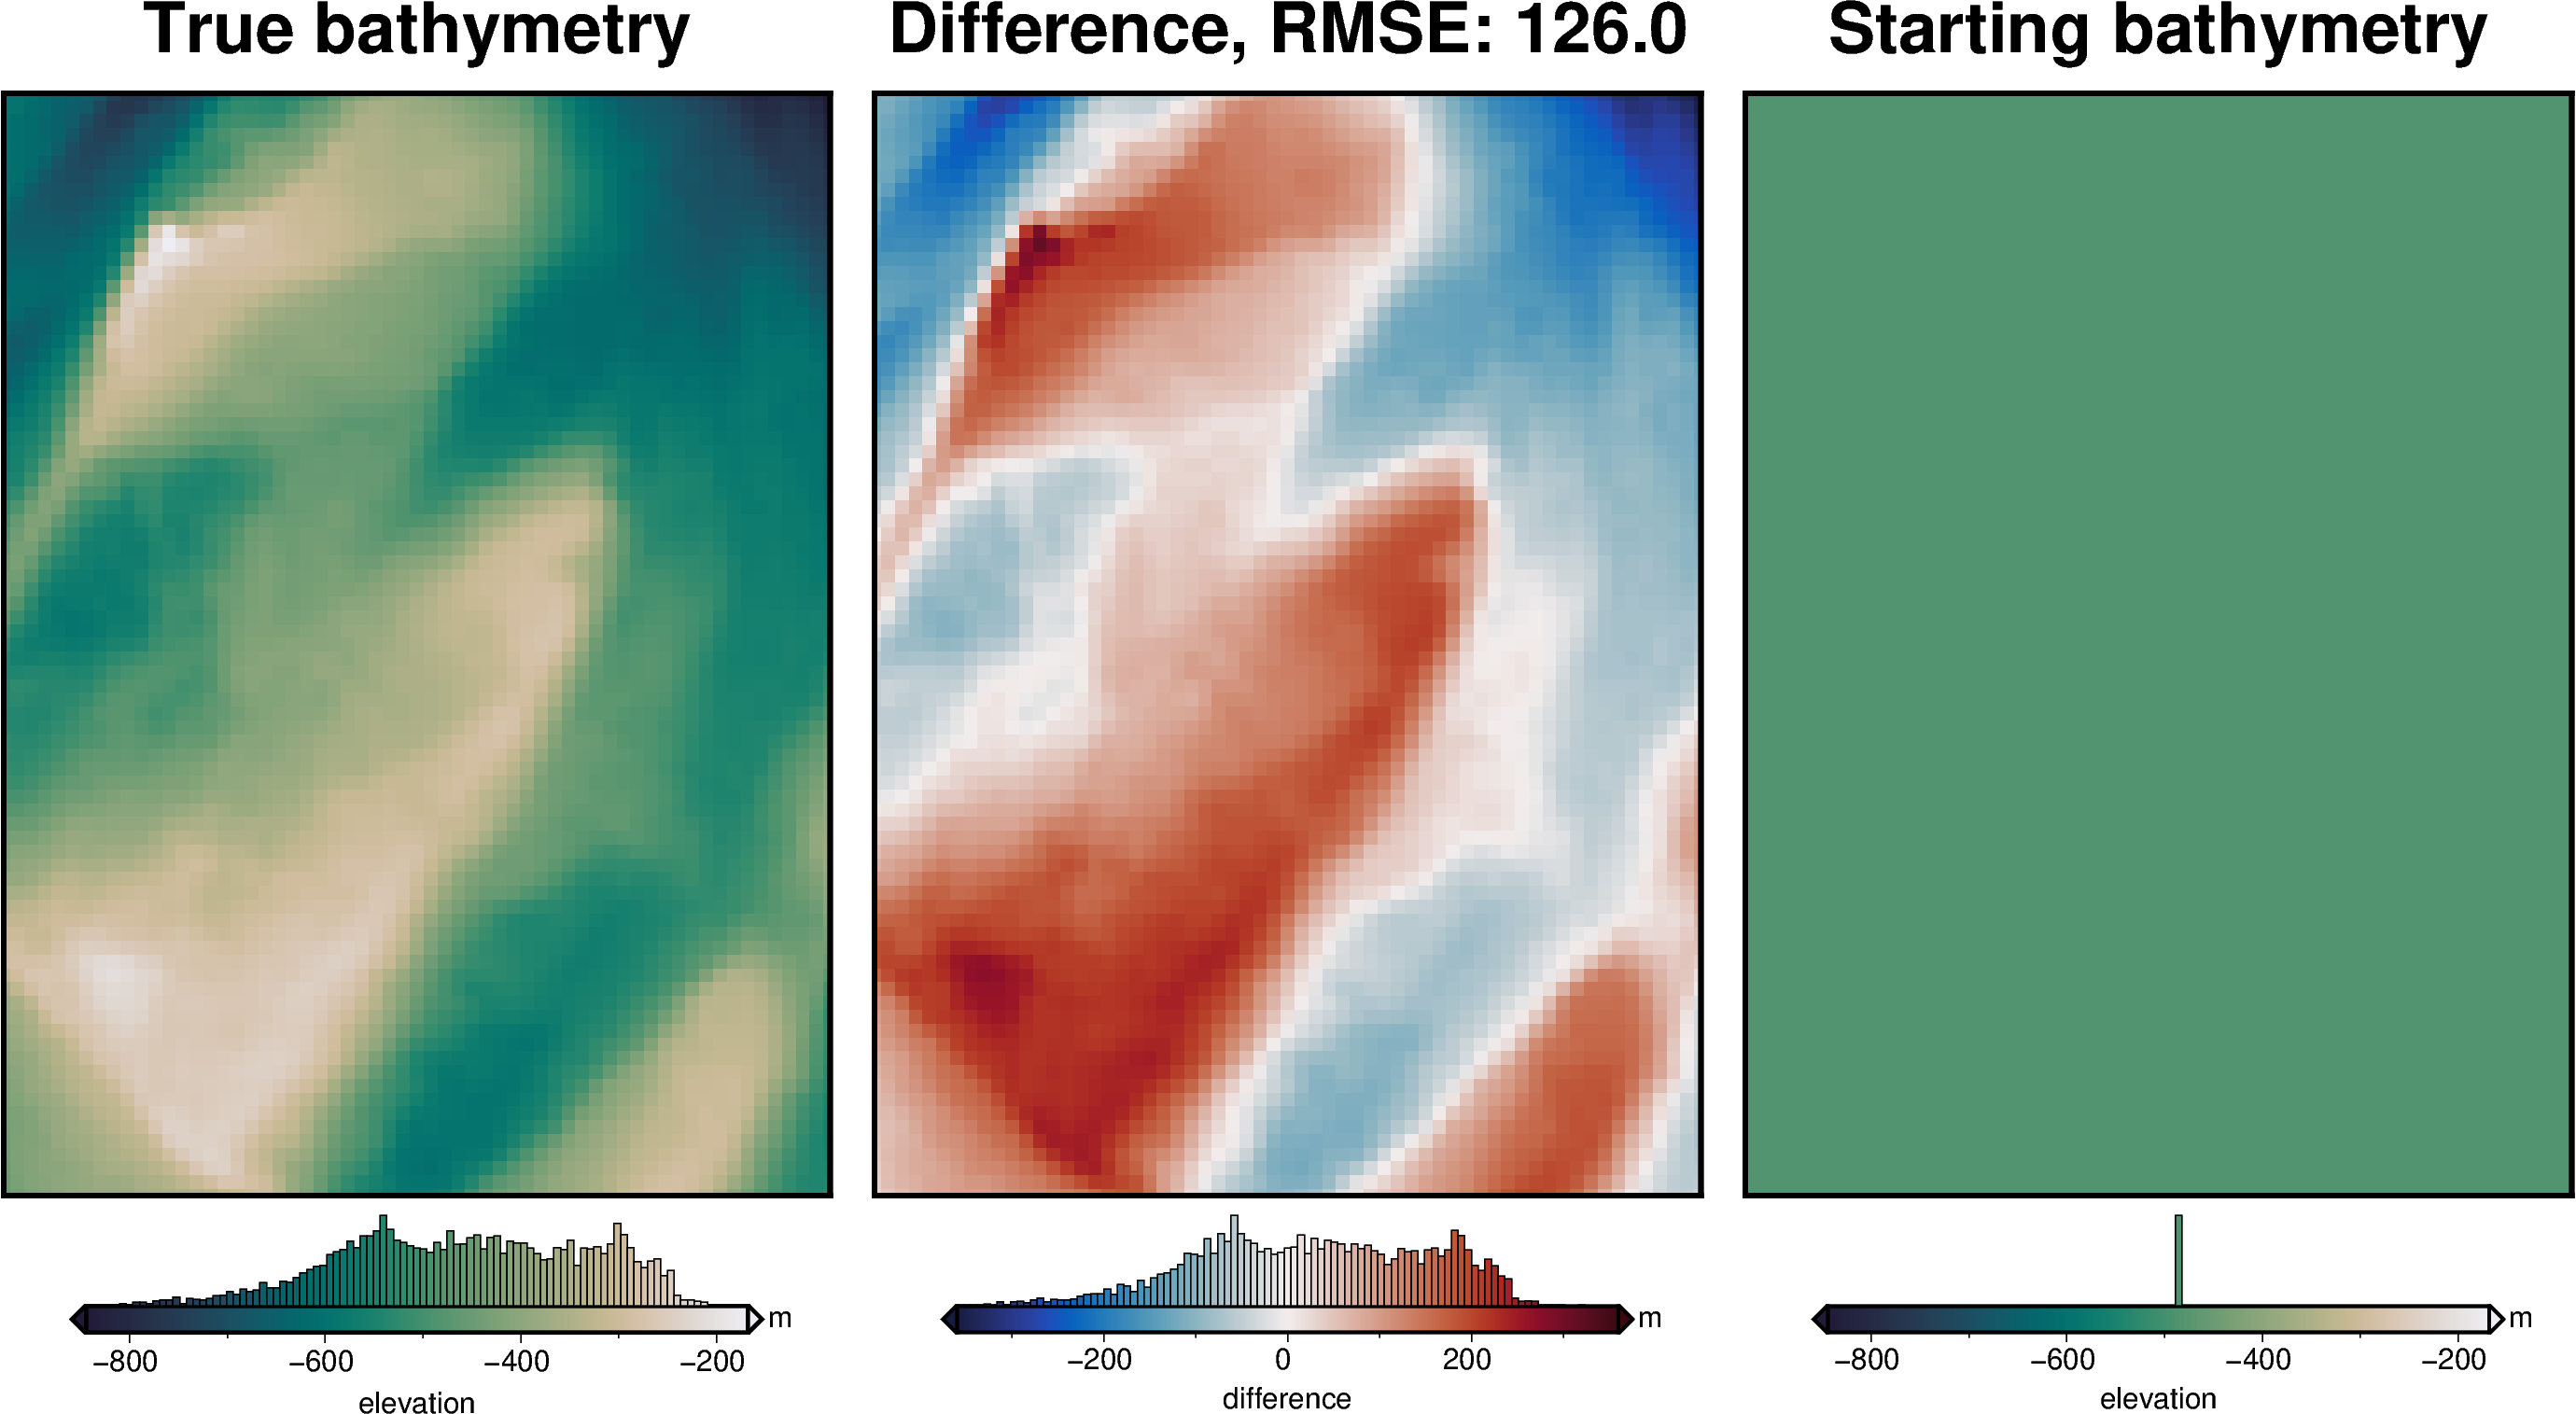

In [5]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
)

In [6]:
# the true density contrast is 1476 kg/m3
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,uncert,gravity_anomaly_no_noise,starting_gravity
0,-1800000.0,-40000.0,1000.0,-28.046289,0,-28.046289,0.0,-28.046289,-29.341524
1,-1800000.0,-35000.0,1000.0,-26.714502,0,-26.714502,0.0,-26.714502,-29.382051
2,-1800000.0,-30000.0,1000.0,-25.919276,0,-25.919276,0.0,-25.919276,-29.412038
3,-1800000.0,-25000.0,1000.0,-25.236960,0,-25.236960,0.0,-25.236960,-29.434973
4,-1800000.0,-20000.0,1000.0,-24.610928,0,-24.610928,0.0,-24.610928,-29.452985
...,...,...,...,...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,0,-48.323584,0.0,-48.323584,-29.452985
4937,-1400000.0,245000.0,1000.0,-48.356131,0,-48.356131,0.0,-48.356131,-29.434973
4938,-1400000.0,250000.0,1000.0,-49.079005,0,-49.079005,0.0,-49.079005,-29.412038
4939,-1400000.0,255000.0,1000.0,-49.877171,0,-49.877171,0.0,-49.877171,-29.382051


# Run ensemble of inversions with varying noise levels

In [7]:
noise_levels = [float(round(x,2)) for x in np.linspace(0, 6, 10)]
noise_levels

[0.0, 0.67, 1.33, 2.0, 2.67, 3.33, 4.0, 4.67, 5.33, 6.0]

In [8]:
# noise_levels = [1.0, 5.0, 8.0]
# noise_levels

INFO:invert4geom:Standard deviation used for noise: [6.0]
INFO:invert4geom:Standard deviation used for noise: [6.0]


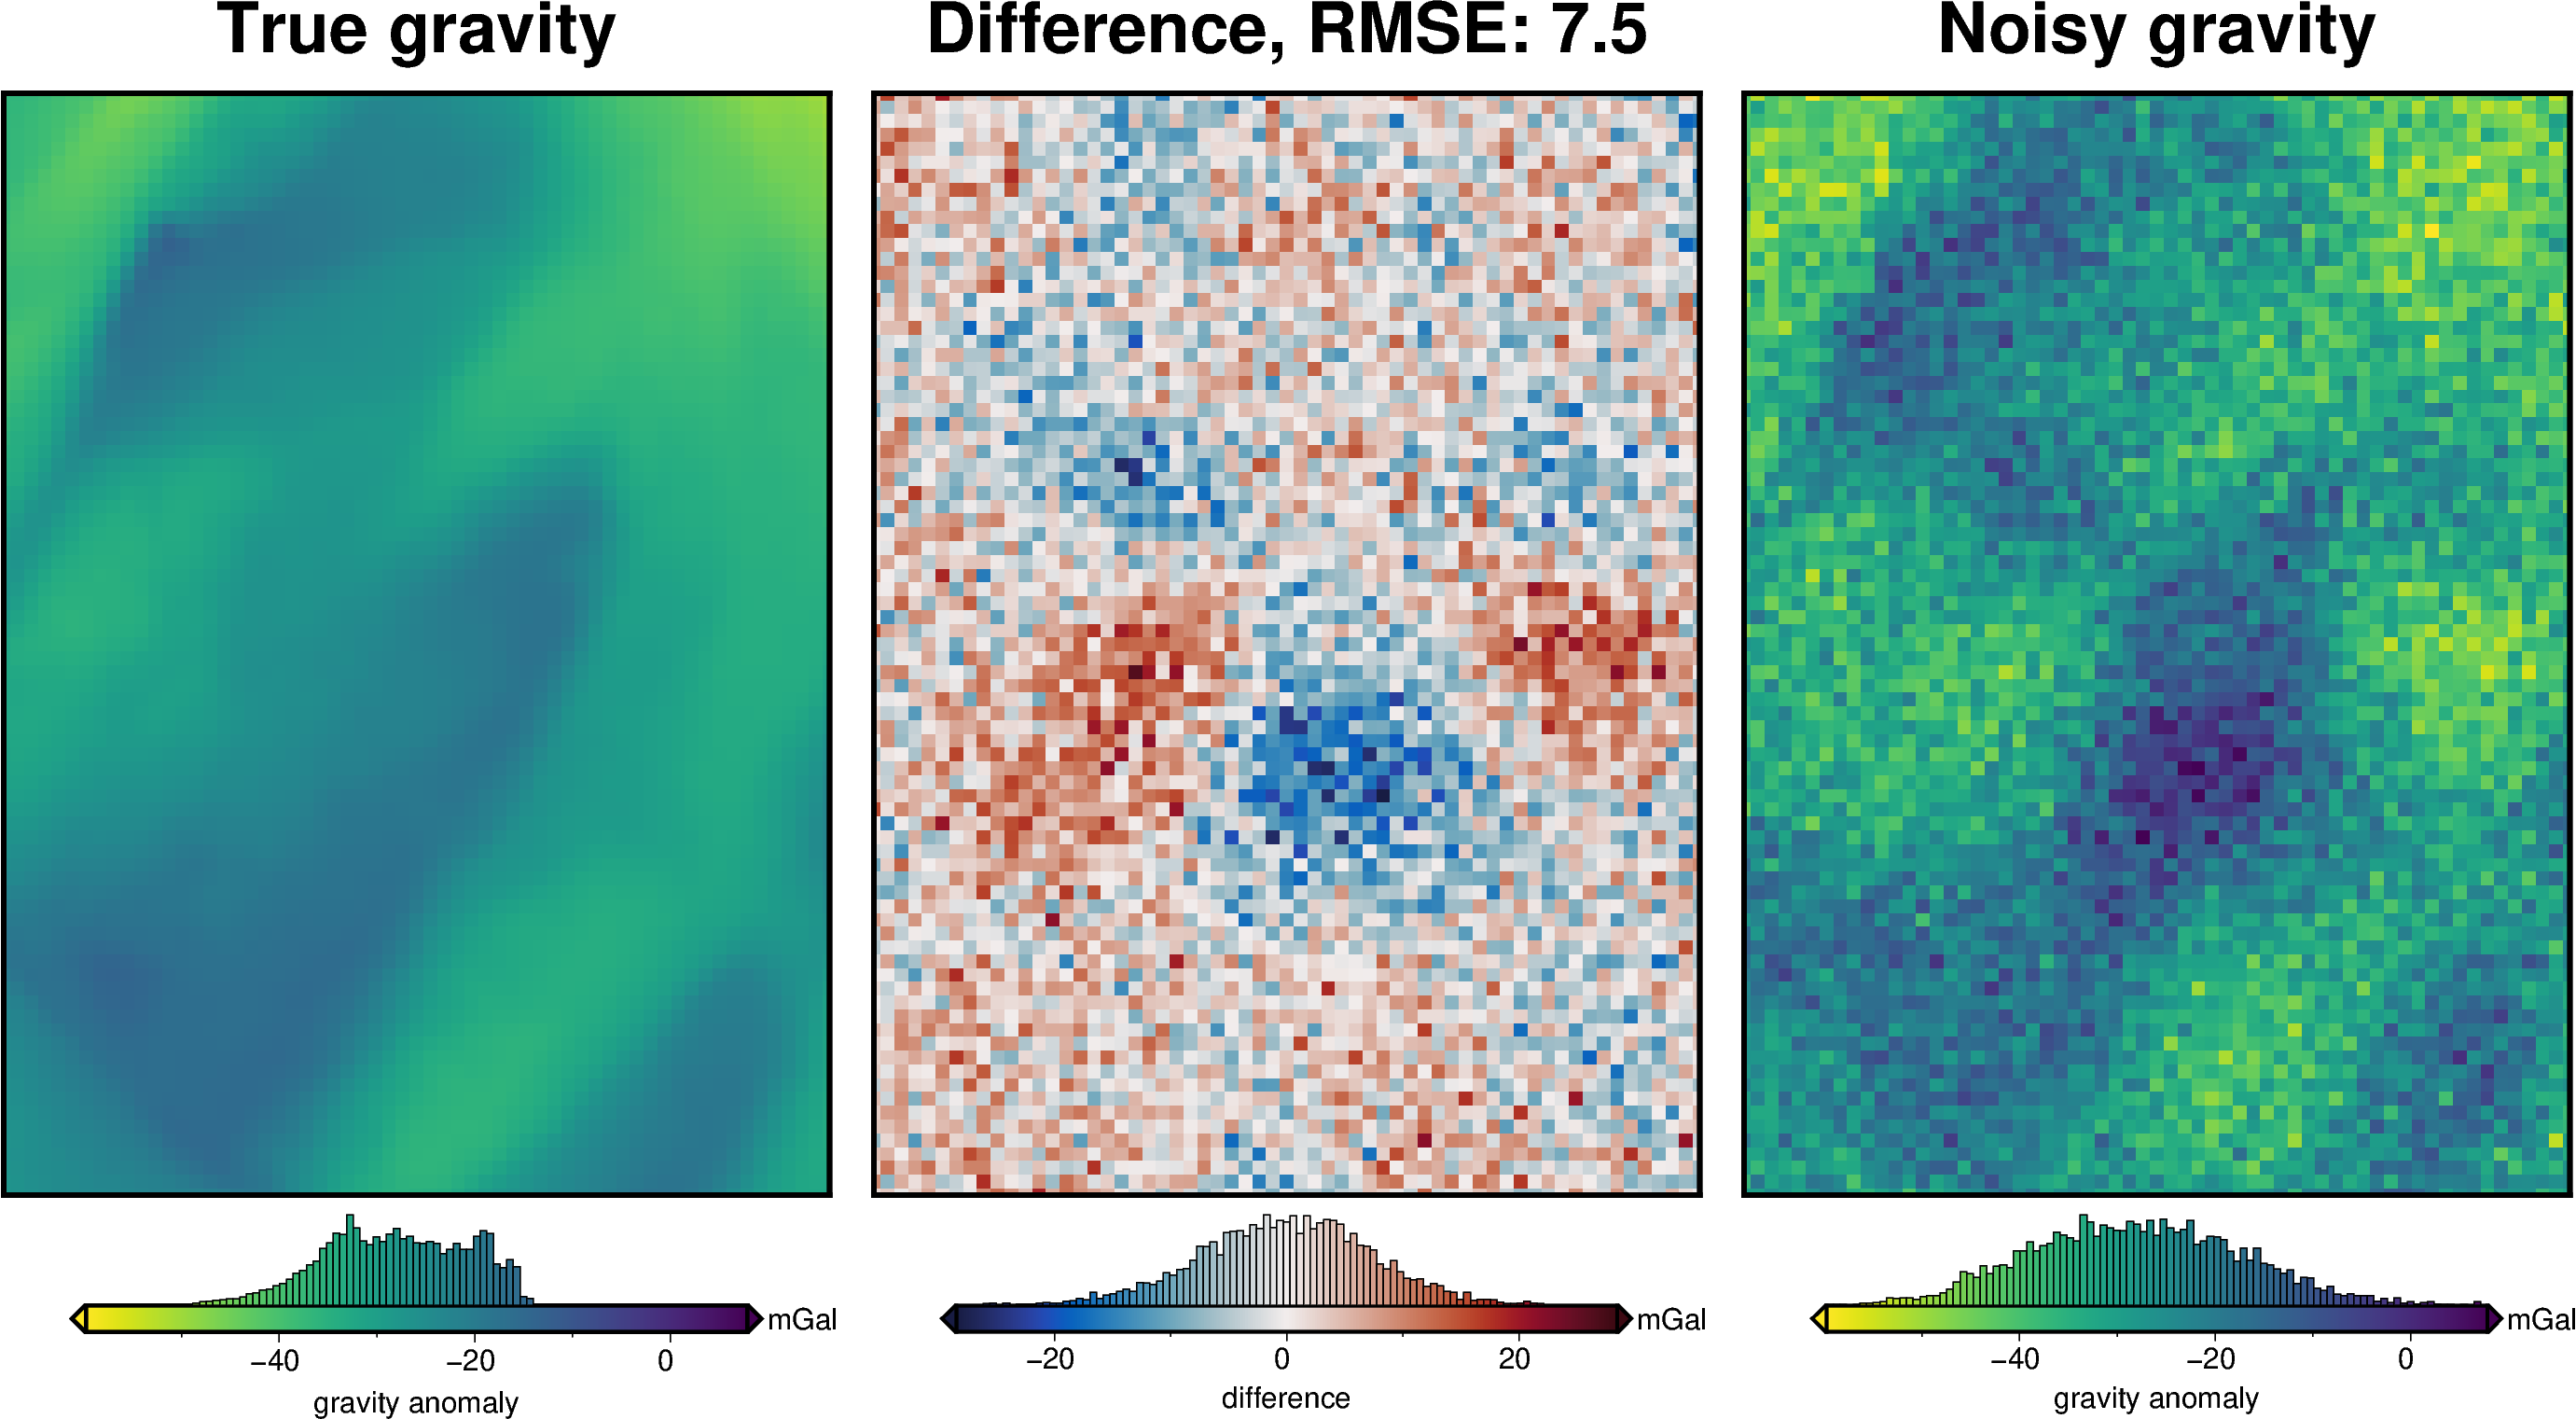

In [52]:
cont = synthetic.contaminate_with_long_wavelength_noise(
    grav_df.set_index(["northing", "easting"]).to_xarray().gravity_anomaly_no_noise,
    coarsen_factor=None,
    spacing=50e3,
    noise_as_percent=False,
    noise=noise_levels[-1],
)
df = vd.grid_to_table(cont.rename("gravity_anomaly")).reset_index(drop=True)
grav_df = pd.merge(grav_df.drop(columns=["gravity_anomaly"], errors="ignore"), df, on=["easting", "northing"])

grav_df["gravity_anomaly"], stddev = synthetic.contaminate(
        grav_df.gravity_anomaly,
        stddev=noise_levels[-1],
        percent=False,
        seed=0
    )

grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

_ = polar_utils.grd_compare(
    grav_grid.gravity_anomaly_no_noise,
    grav_grid.gravity_anomaly,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="viridis",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True gravity",
    grid2_name="Noisy gravity",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="mGal",
    cbar_label="gravity anomaly",
    RMSE_decimals=1,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
)

INFO:invert4geom:Standard deviation used for noise: [0.67]
INFO:invert4geom:Standard deviation used for noise: [0.67]
INFO:invert4geom:Standard deviation used for noise: [1.33]
INFO:invert4geom:Standard deviation used for noise: [1.33]
INFO:invert4geom:Standard deviation used for noise: [2.0]
INFO:invert4geom:Standard deviation used for noise: [2.0]
INFO:invert4geom:Standard deviation used for noise: [2.67]
INFO:invert4geom:Standard deviation used for noise: [2.67]
INFO:invert4geom:Standard deviation used for noise: [3.33]
INFO:invert4geom:Standard deviation used for noise: [3.33]
INFO:invert4geom:Standard deviation used for noise: [4.0]
INFO:invert4geom:Standard deviation used for noise: [4.0]
INFO:invert4geom:Standard deviation used for noise: [4.67]
INFO:invert4geom:Standard deviation used for noise: [4.67]
INFO:invert4geom:Standard deviation used for noise: [5.33]
INFO:invert4geom:Standard deviation used for noise: [5.33]
INFO:invert4geom:Standard deviation used for noise: [6.0]
IN

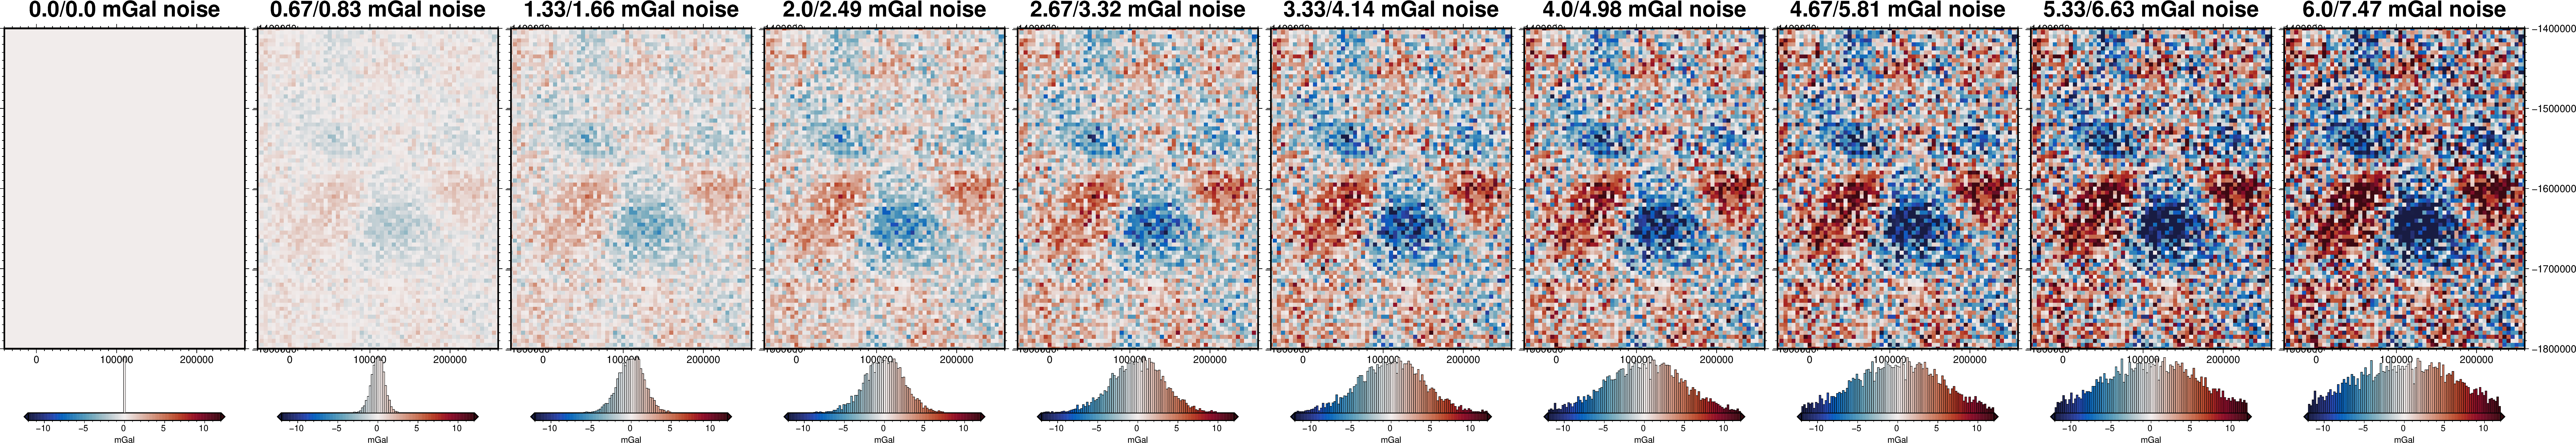

In [53]:
grav_dfs = []
grav_grids = []
for i, n in enumerate(noise_levels):
    # contaminated with long-wavelength noise
    contaminated = synthetic.contaminate_with_long_wavelength_noise(
        grav_df.set_index(["northing", "easting"]).to_xarray().gravity_anomaly_no_noise,
        coarsen_factor=None,
        spacing=50e3,
        noise_as_percent=False,
        noise=n,
    )
    contaminated_df = vd.grid_to_table(contaminated.rename("gravity_anomaly")).reset_index(drop=True)

    # copy gravity dataframe
    df = copy.deepcopy(grav_df)

    df = pd.merge(df.drop(columns=["gravity_anomaly"], errors="ignore"), contaminated_df, on=["easting", "northing"])

    # contaminate gravity with random noise
    df["gravity_anomaly"], stddev = synthetic.contaminate(
        df.gravity_anomaly,
        stddev=n,
        percent=False,
        seed=0
    )

    df = regional.regional_separation(
        grav_df=df,
        method="constant",
        constant=0,
    )

    grav_dfs.append(df)

    grav_grid = df.set_index(["northing", "easting"]).to_xarray()
    grav_grids.append(grav_grid)


for i, g in enumerate(grav_grids):
    if i == 0:
        fig = None
        origin_shift="initialize"

    else:
        origin_shift="xshift"

    cpt_lims=[-2*max(noise_levels), 2*max(noise_levels)]

    dif = (g.gravity_anomaly_no_noise - g.gravity_anomaly)
    fig = maps.plot_grd(
        # grav_grid.res,
        dif,
        region=inversion_region,
        fig_height=10,
        fig=fig,
        origin_shift=origin_shift,
        title=f"{round(noise_levels[i],2)}/{round(utils.rmse(dif),2)} mGal noise",
        cmap="balance+h0",
        cpt_lims=cpt_lims,
        hist=True,
        cbar_label="mGal",
        frame=["nSwE", "xaf10000", "yaf10000"],
    )



fig.show()

In [54]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "delta_l2_norm_tolerance": 1.008,
}


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_0.0_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.041517870851022064}
INFO:invert4geom:	scores: [0.12774510281706072]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_0.0_mGal_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_0.67_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.024577958705414526}
INFO:invert4geom:	scores: [0.21025648141429246]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_0.67_mGal_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_1.33_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.024577958705414526}
INFO:invert4geom:	scores: [0.29635419913155325]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_1.33_mGal_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_2.0_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.02457795972125575}
INFO:invert4geom:	scores: [0.40167437816141427]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_2.0_mGal_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_2.67_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.024577958705414536}
INFO:invert4geom:	scores: [0.5141768215992469]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_2.67_mGal_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_3.33_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.024577958705414536}
INFO:invert4geom:	scores: [0.6283625233533202]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_3.33_mGal_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_4.0_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.02457795972125576}
INFO:invert4geom:	scores: [0.7461295604568509]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_4.0_mGal_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_4.67_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.024577958705414536}
INFO:invert4geom:	scores: [0.8650470998596238]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_4.67_mGal_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_5.33_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.02457795972125576}
INFO:invert4geom:	scores: [0.9829548945017978]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_5.33_mGal_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_05_damping_cv_noise_6.0_mGal'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.024577958705414536}
INFO:invert4geom:	scores: [1.103231880796204]
INFO:invert4geom:results saved to ../../results/Ross_Sea_05_damping_cv_noise_6.0_mGal_results.pickle.pickle


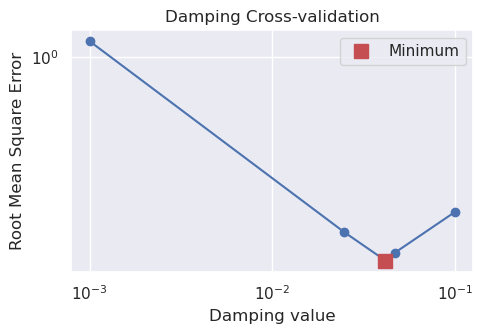

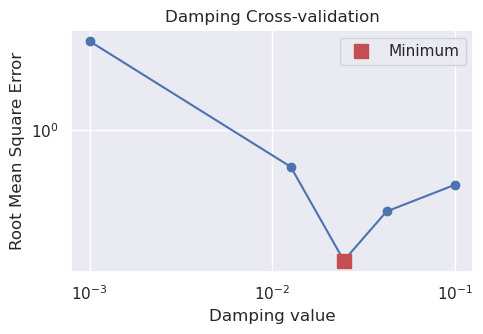

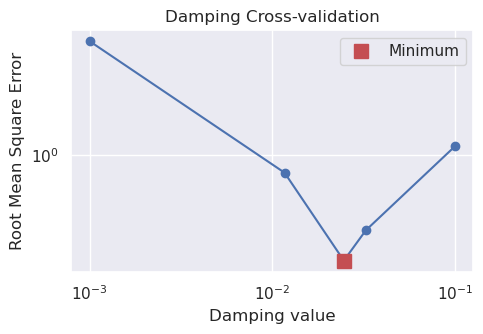

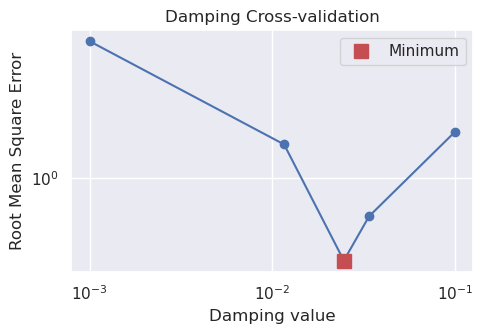

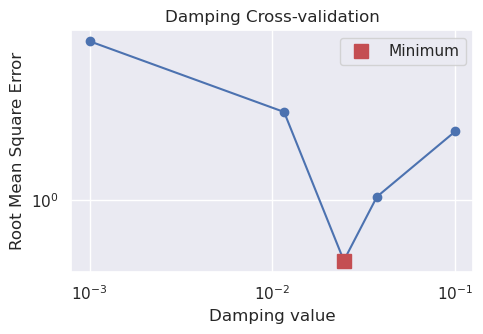

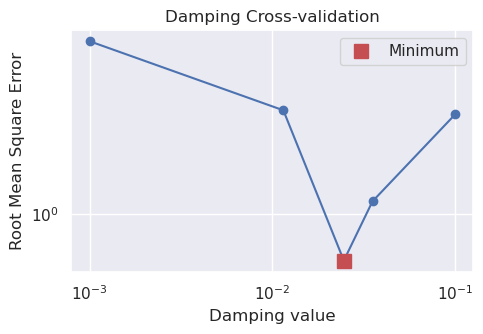

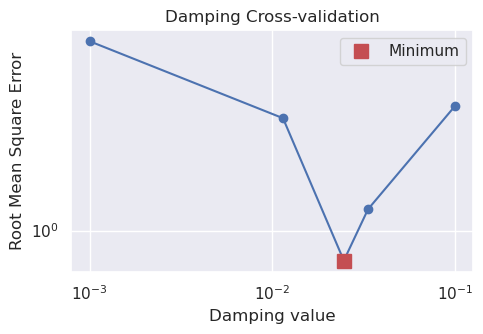

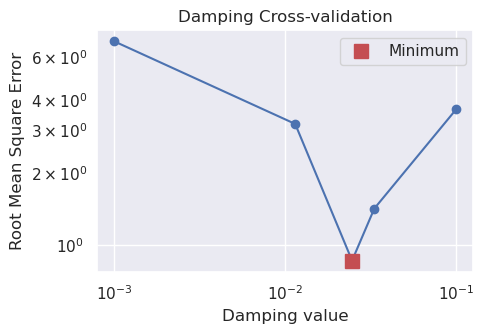

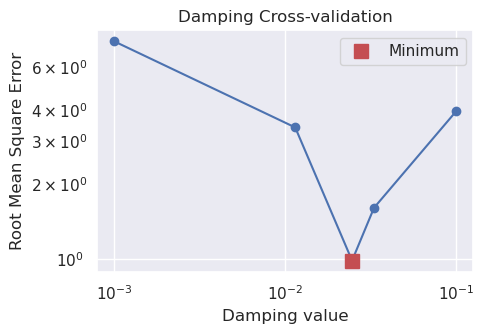

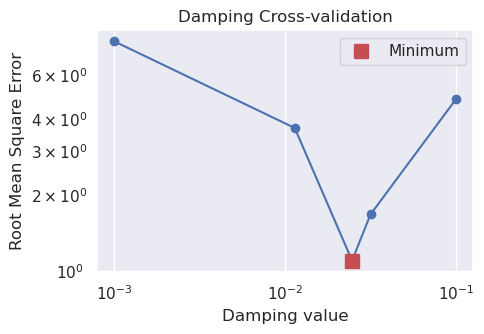

In [63]:
# logging.getLogger().setLevel(logging.WARN)
logging.getLogger().setLevel(logging.INFO)

for i, df in enumerate(tqdm(grav_dfs)):

    if i == 0:
        l2_norm_tolerance = .5
    else:
        l2_norm_tolerance=noise_levels[i]**.5
    # if i > 0:
    #     break
    # run the inversion workflow, including a cross validation for the damping parameter
    inversion.run_inversion_workflow(
        grav_df=df,
        starting_prisms=starting_prisms,
        # for creating test/train splits
        grav_spacing=spacing,
        inversion_region=inversion_region,
        # solver_damping = 0.02,
        run_damping_cv=True,
        damping_limits=(0.001, 0.1),
        damping_cv_trials=5,
        plot_cv=True,
        fname=f"../../results/Ross_Sea_05_damping_cv_noise_{noise_levels[i]}_mGal",
        l2_norm_tolerance=l2_norm_tolerance,
        **kwargs,
    )



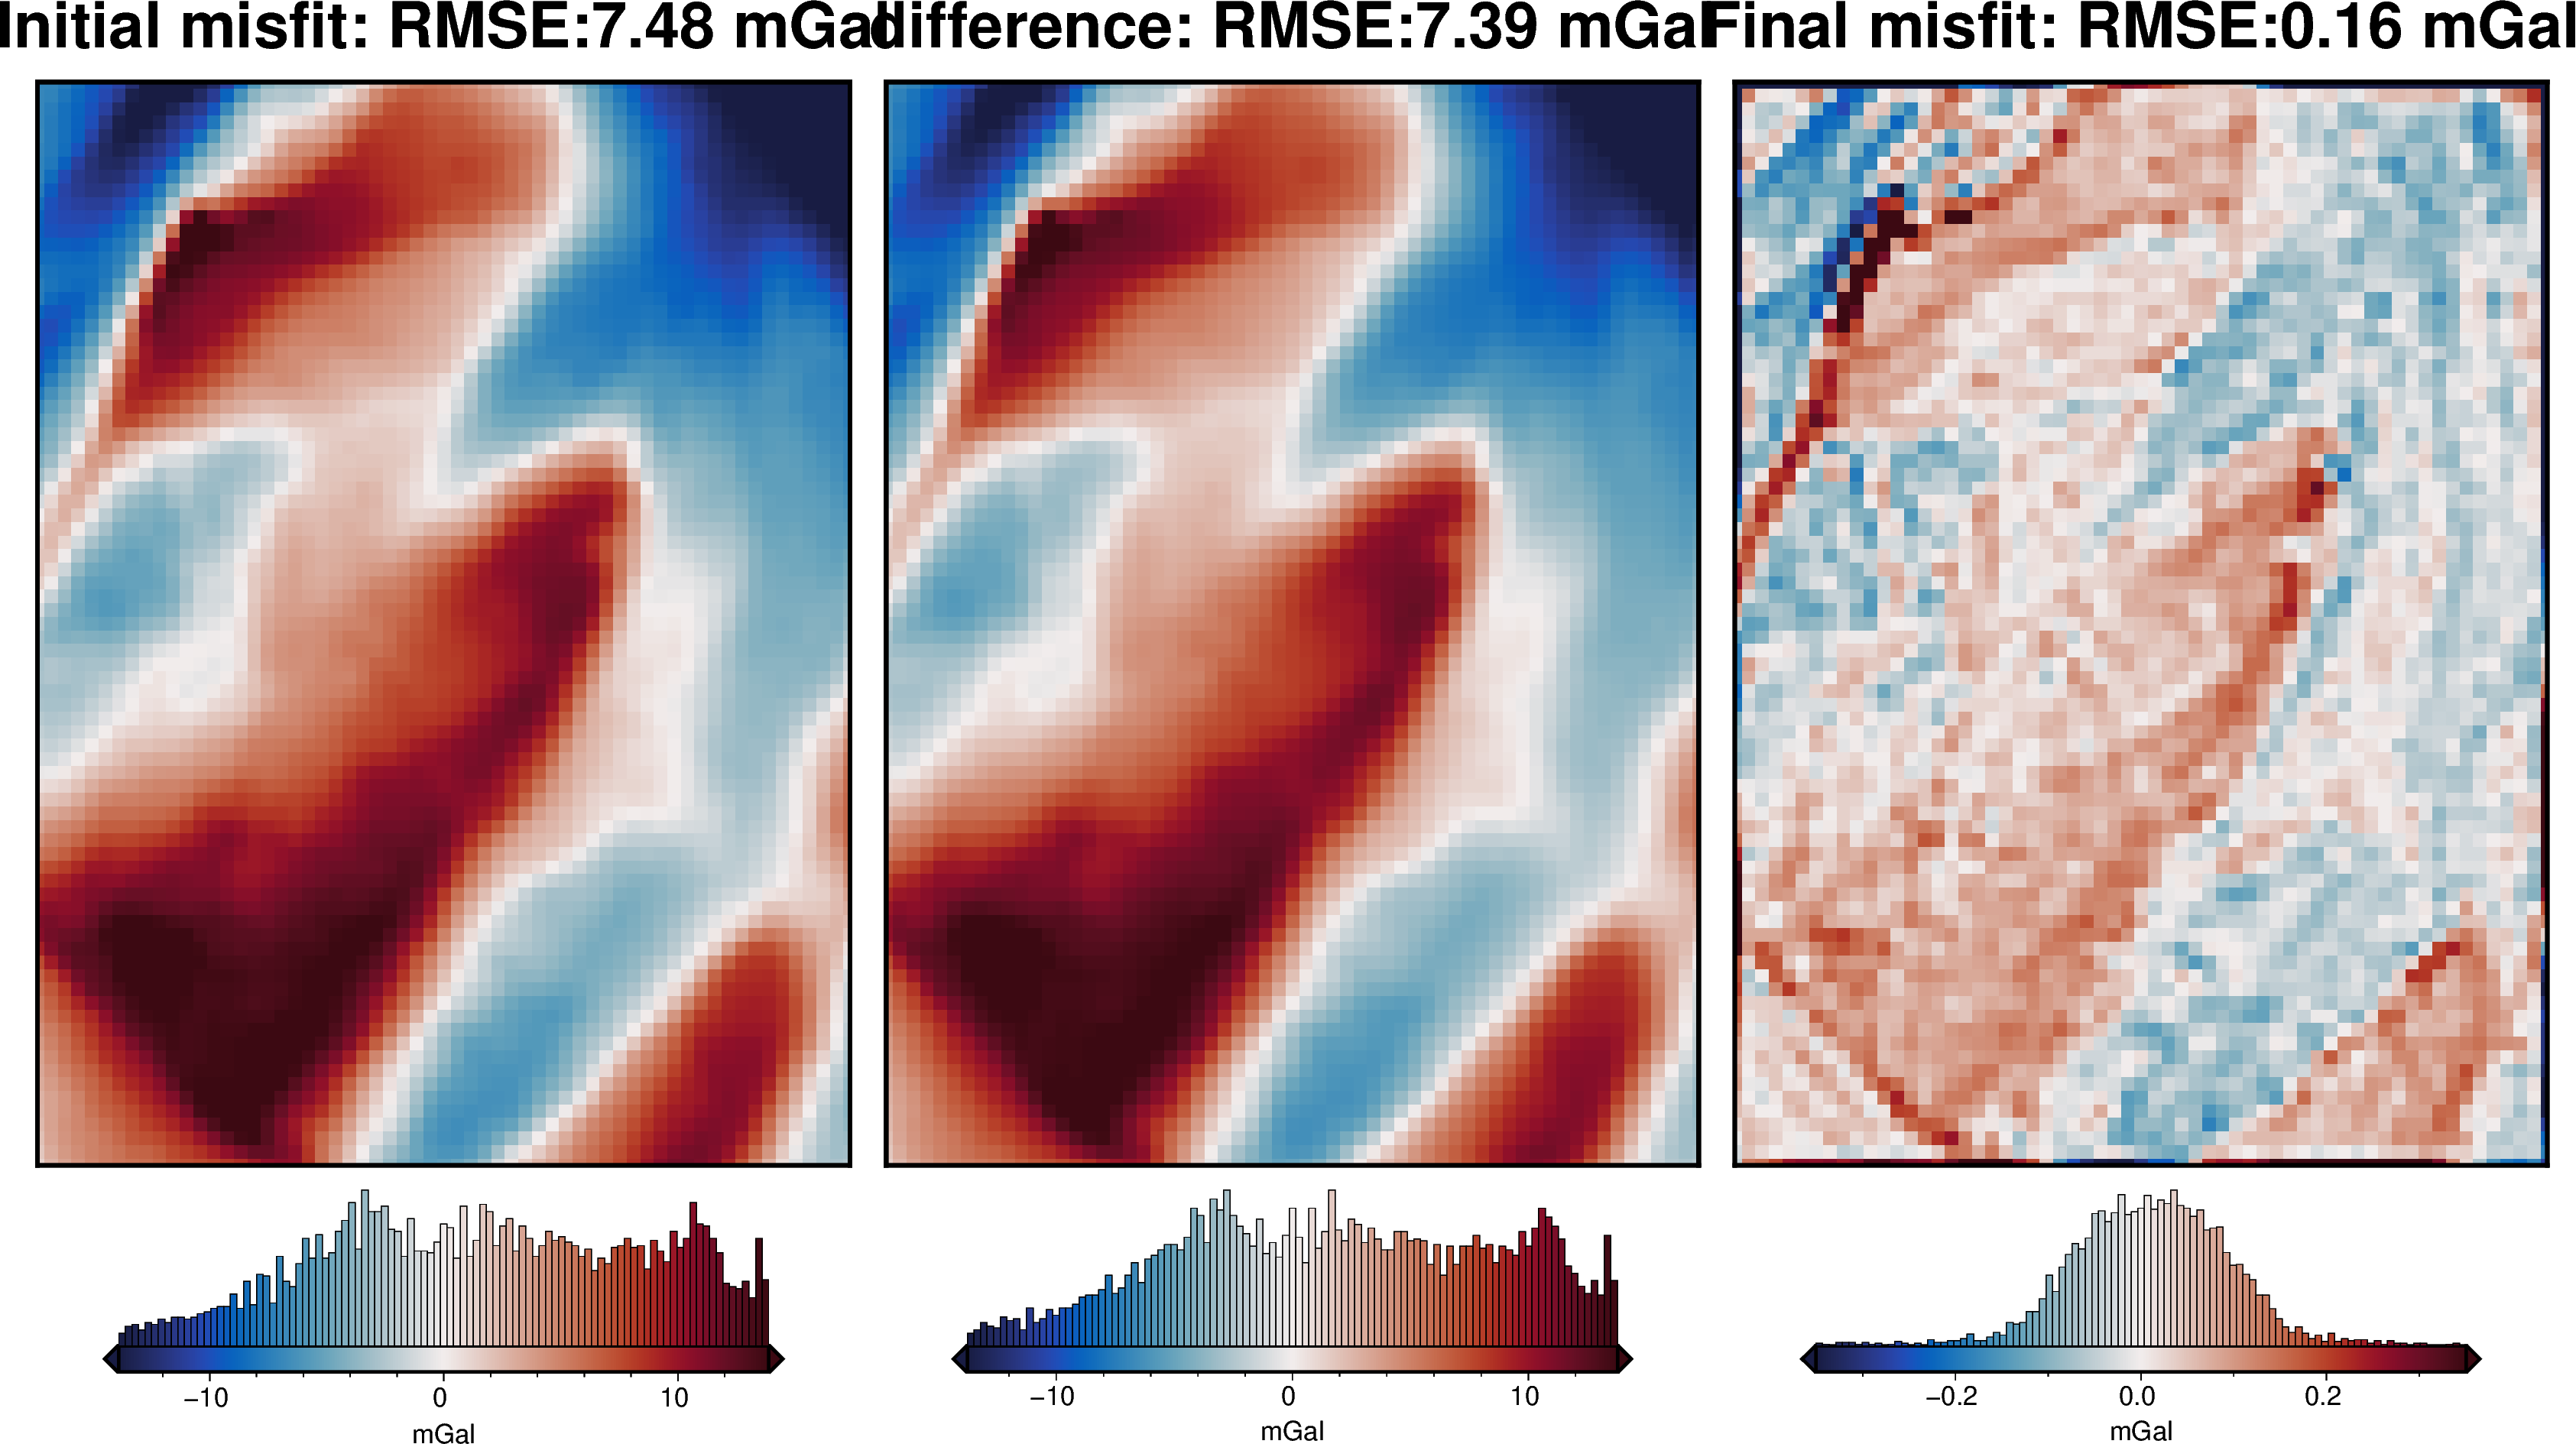

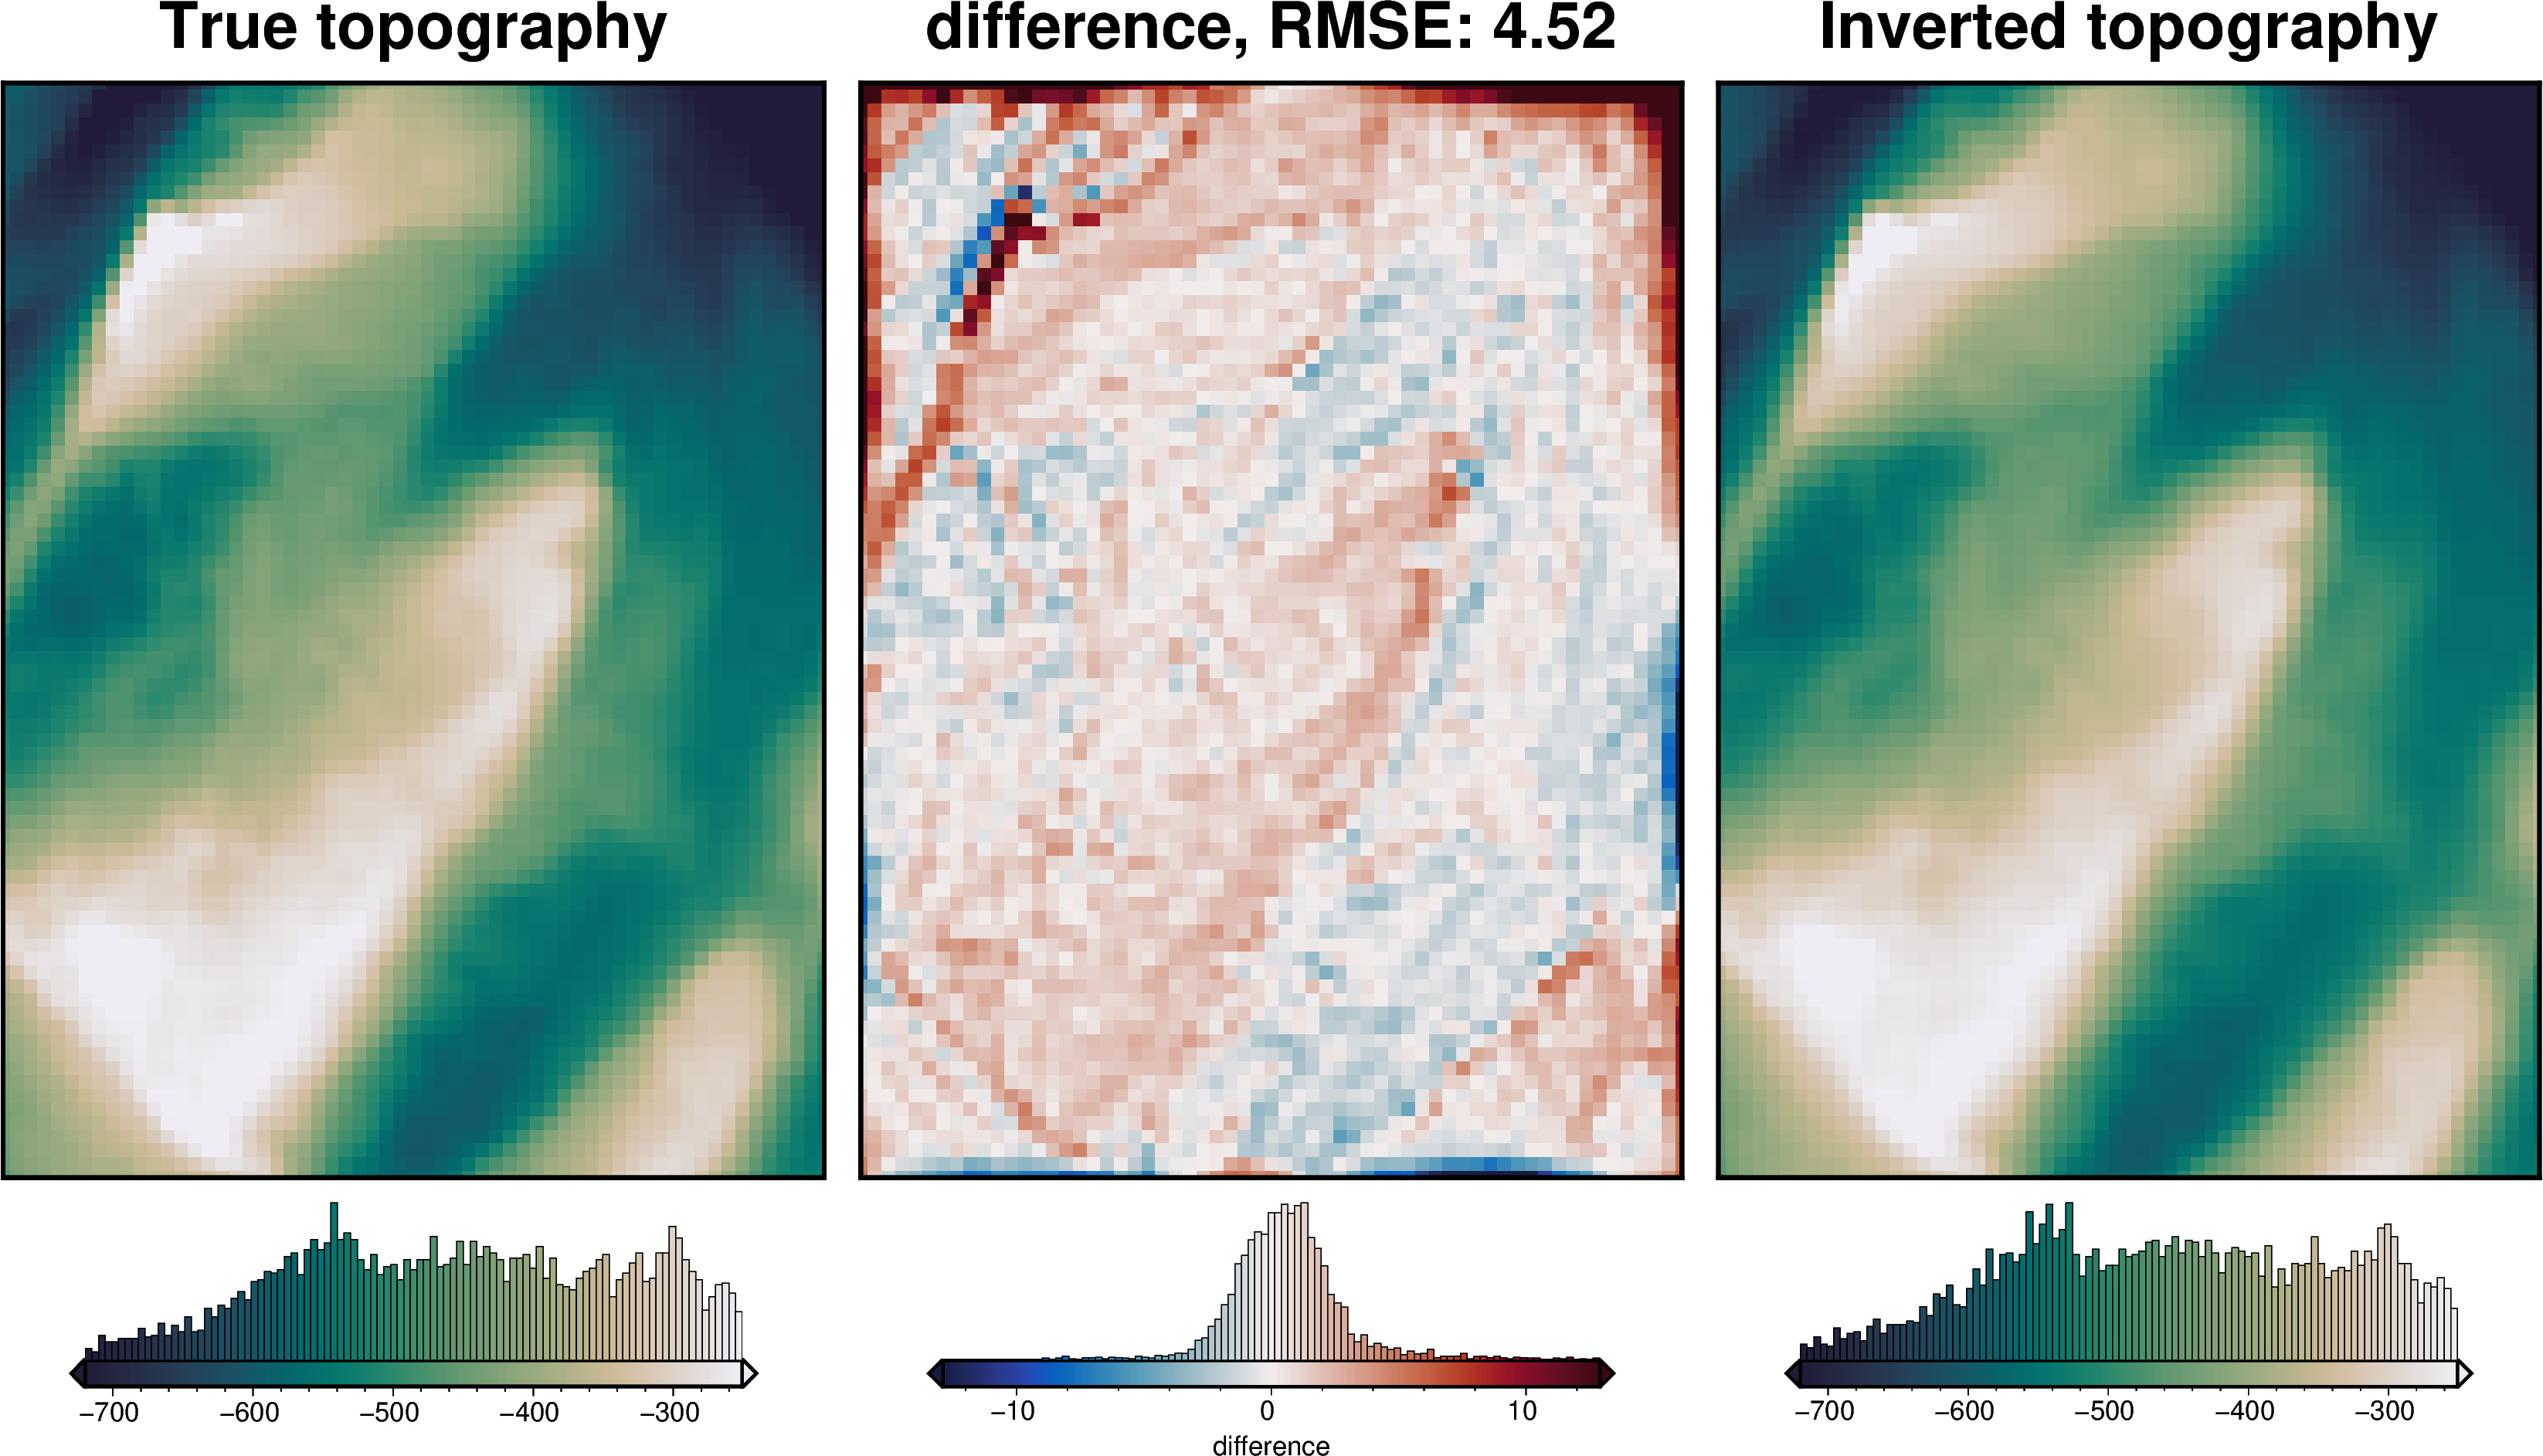

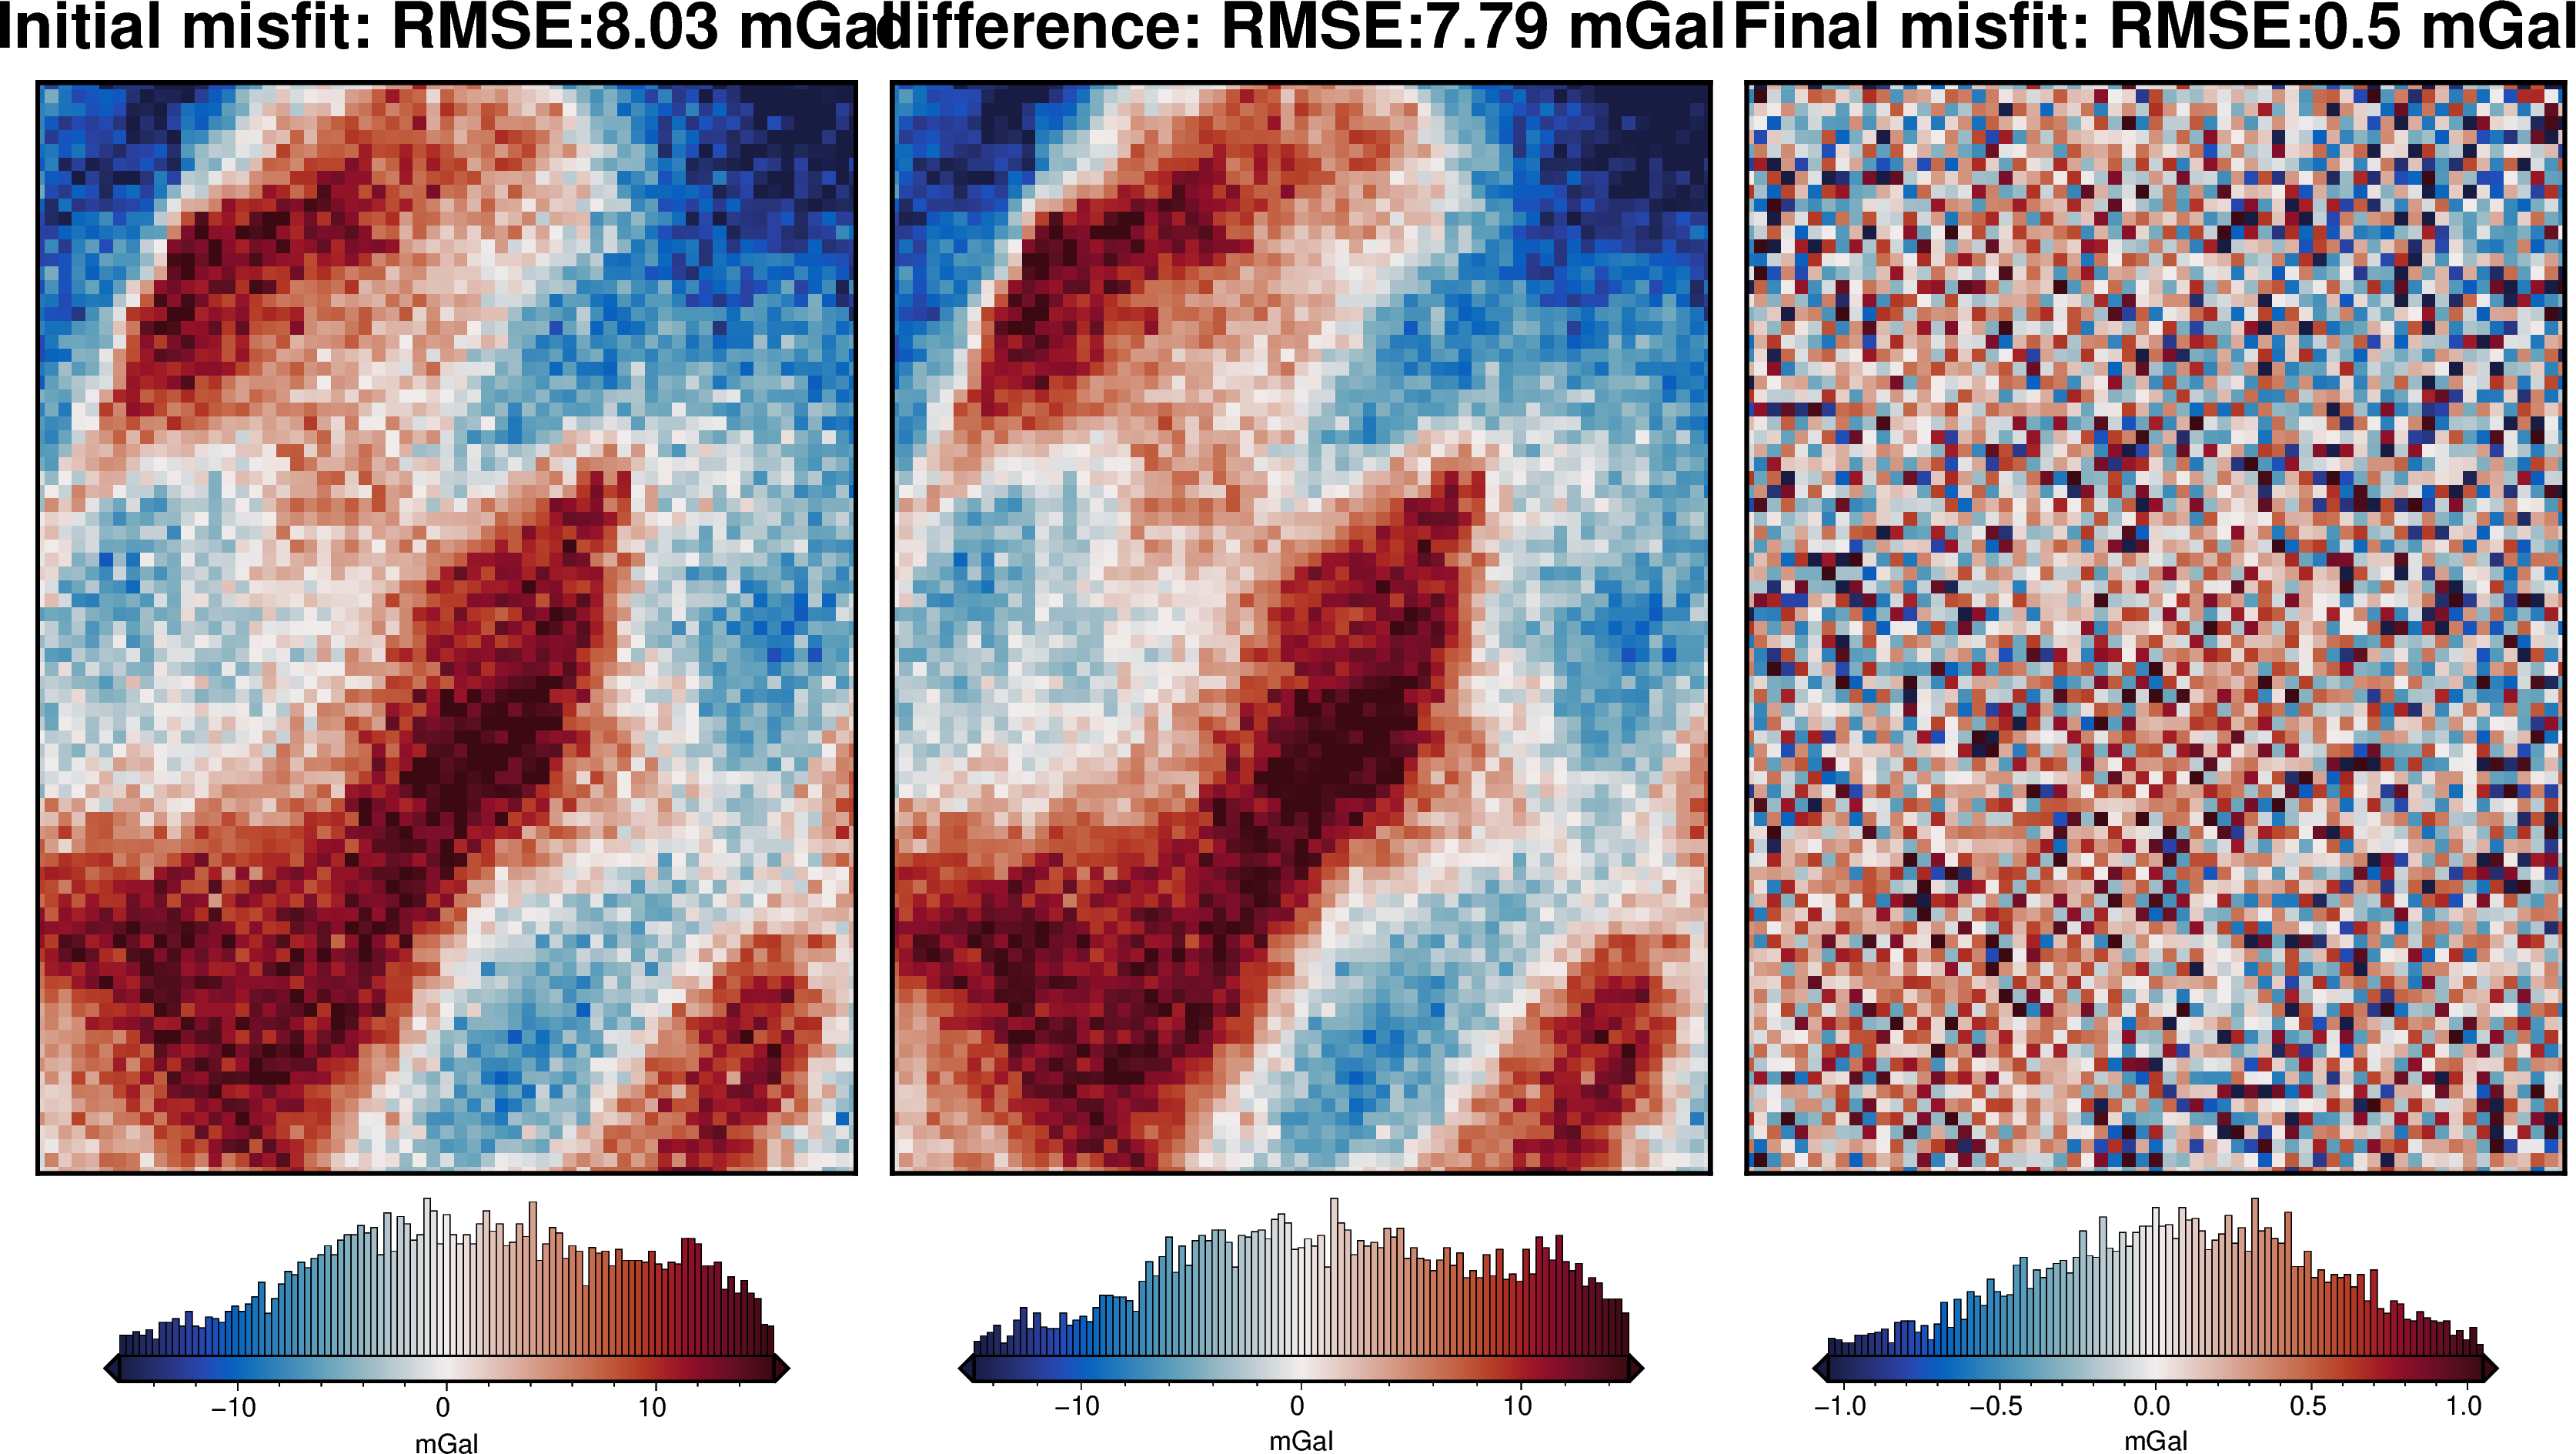

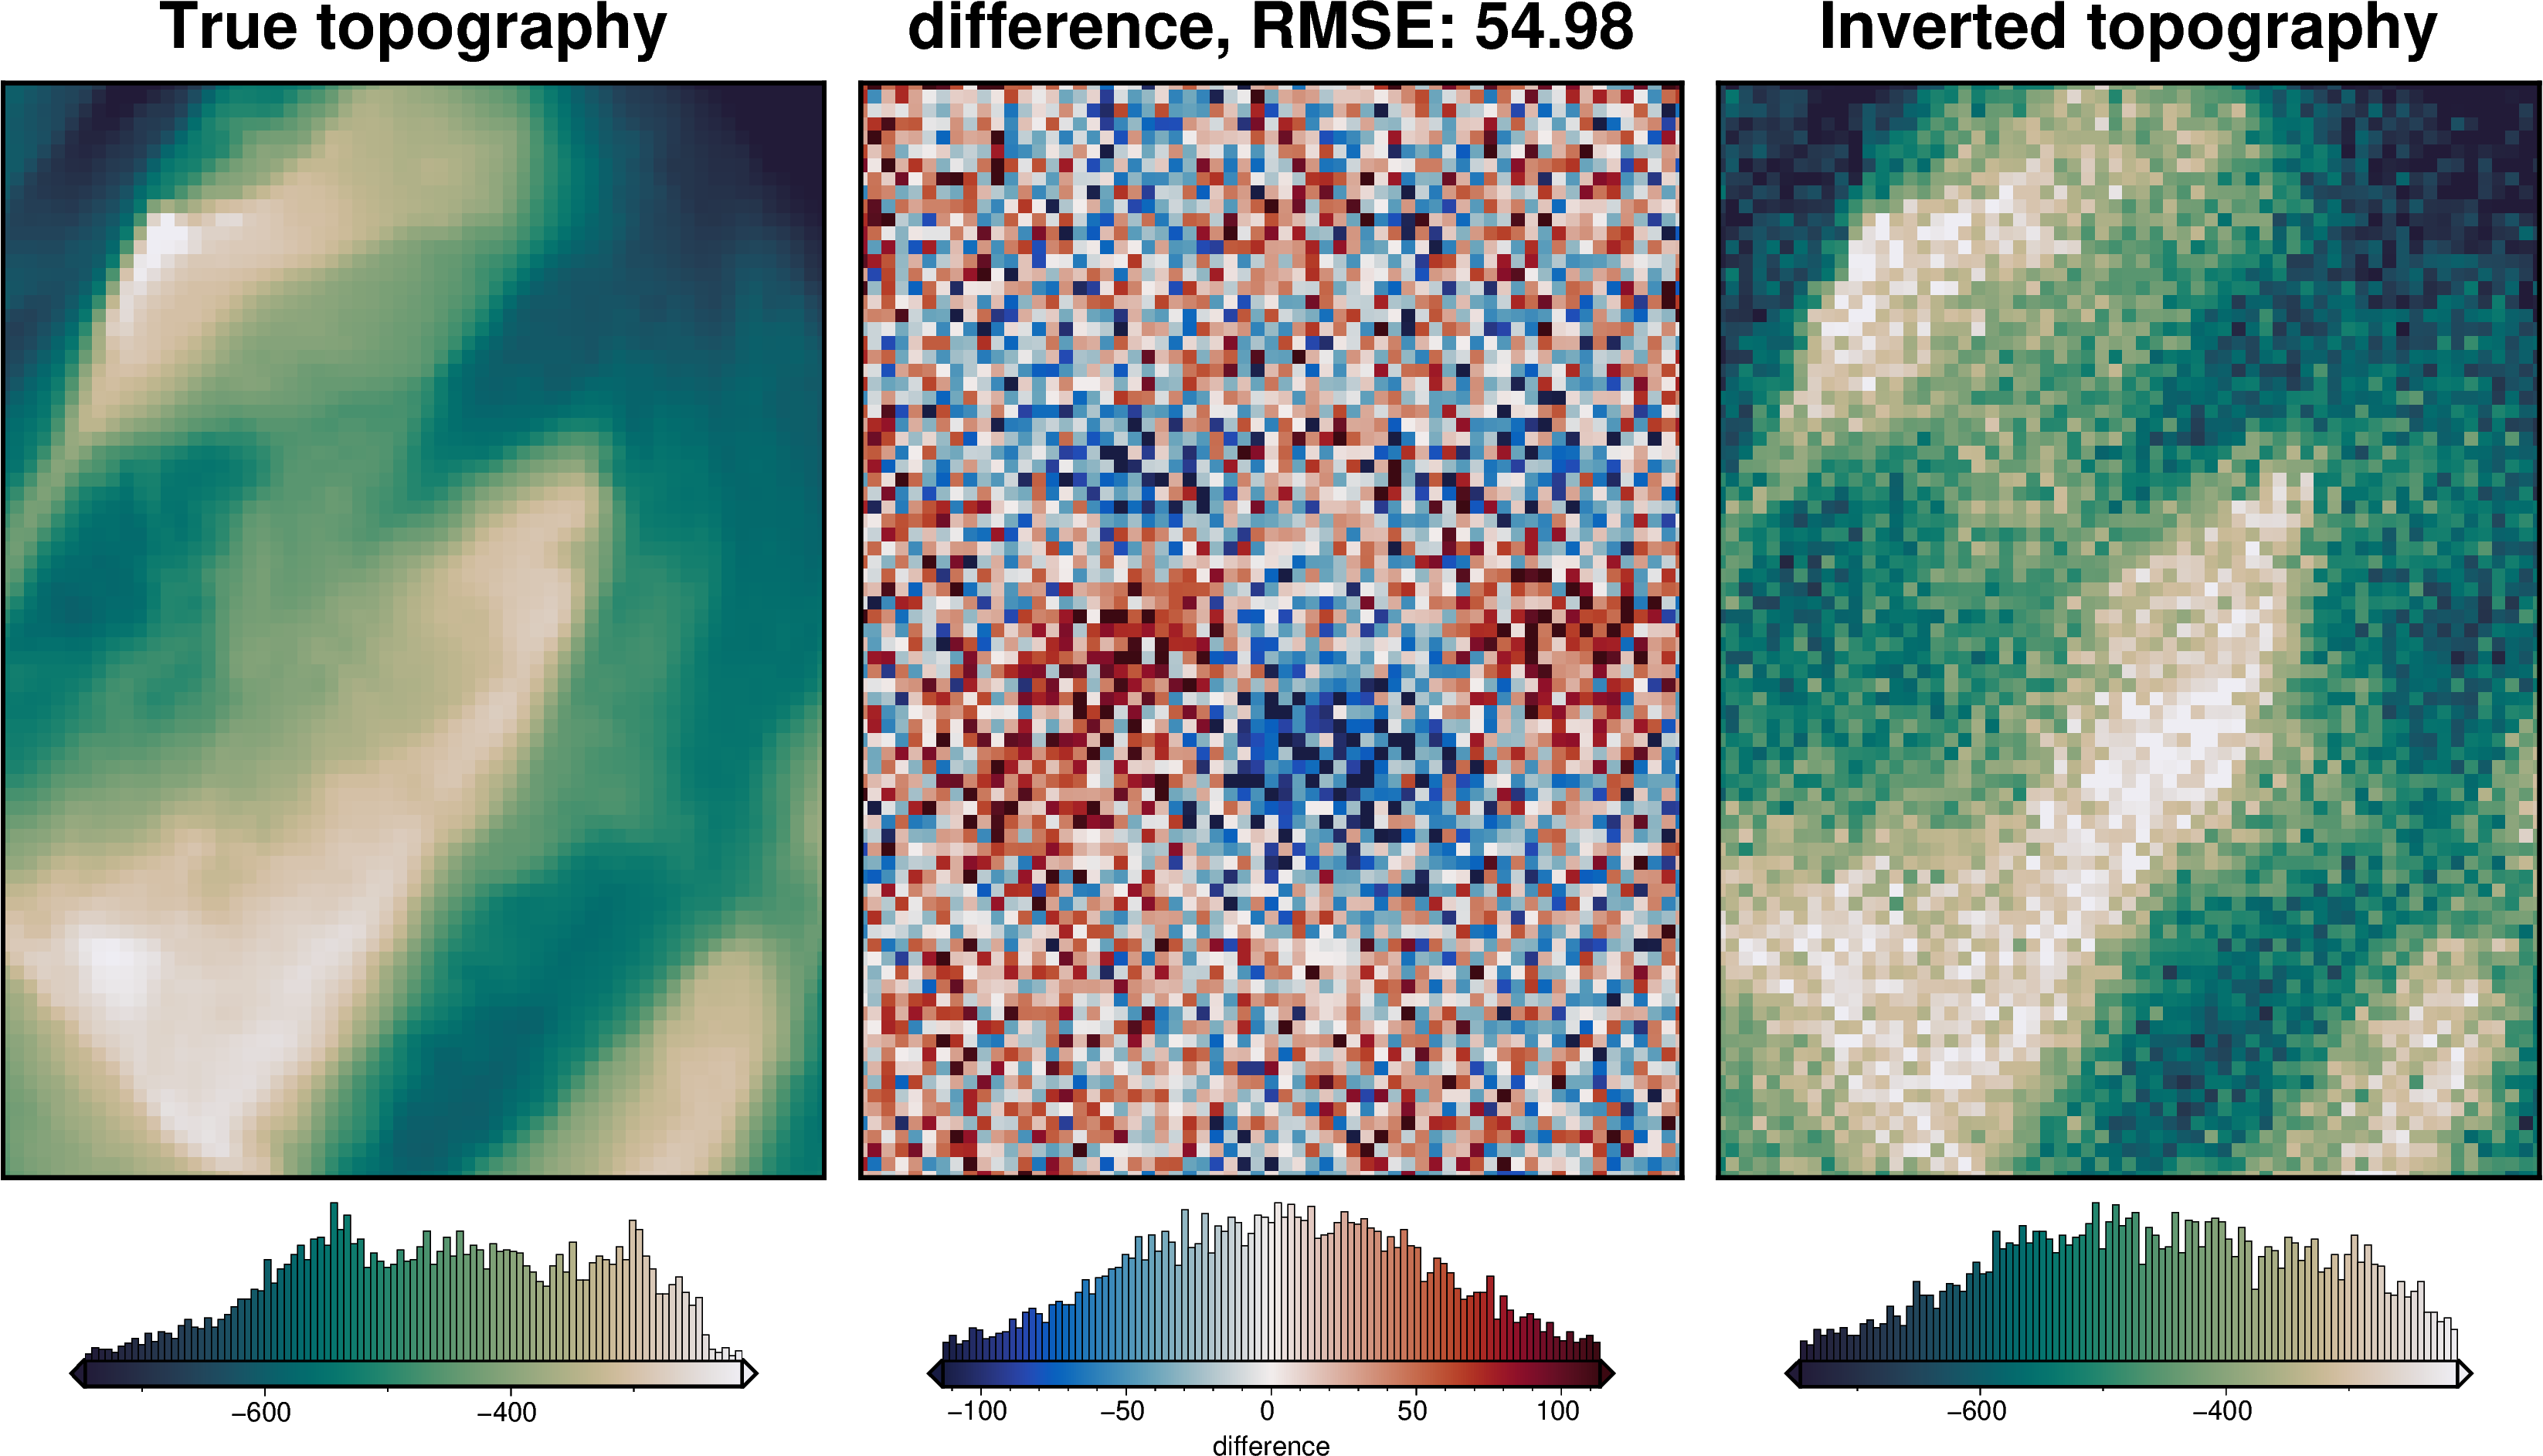

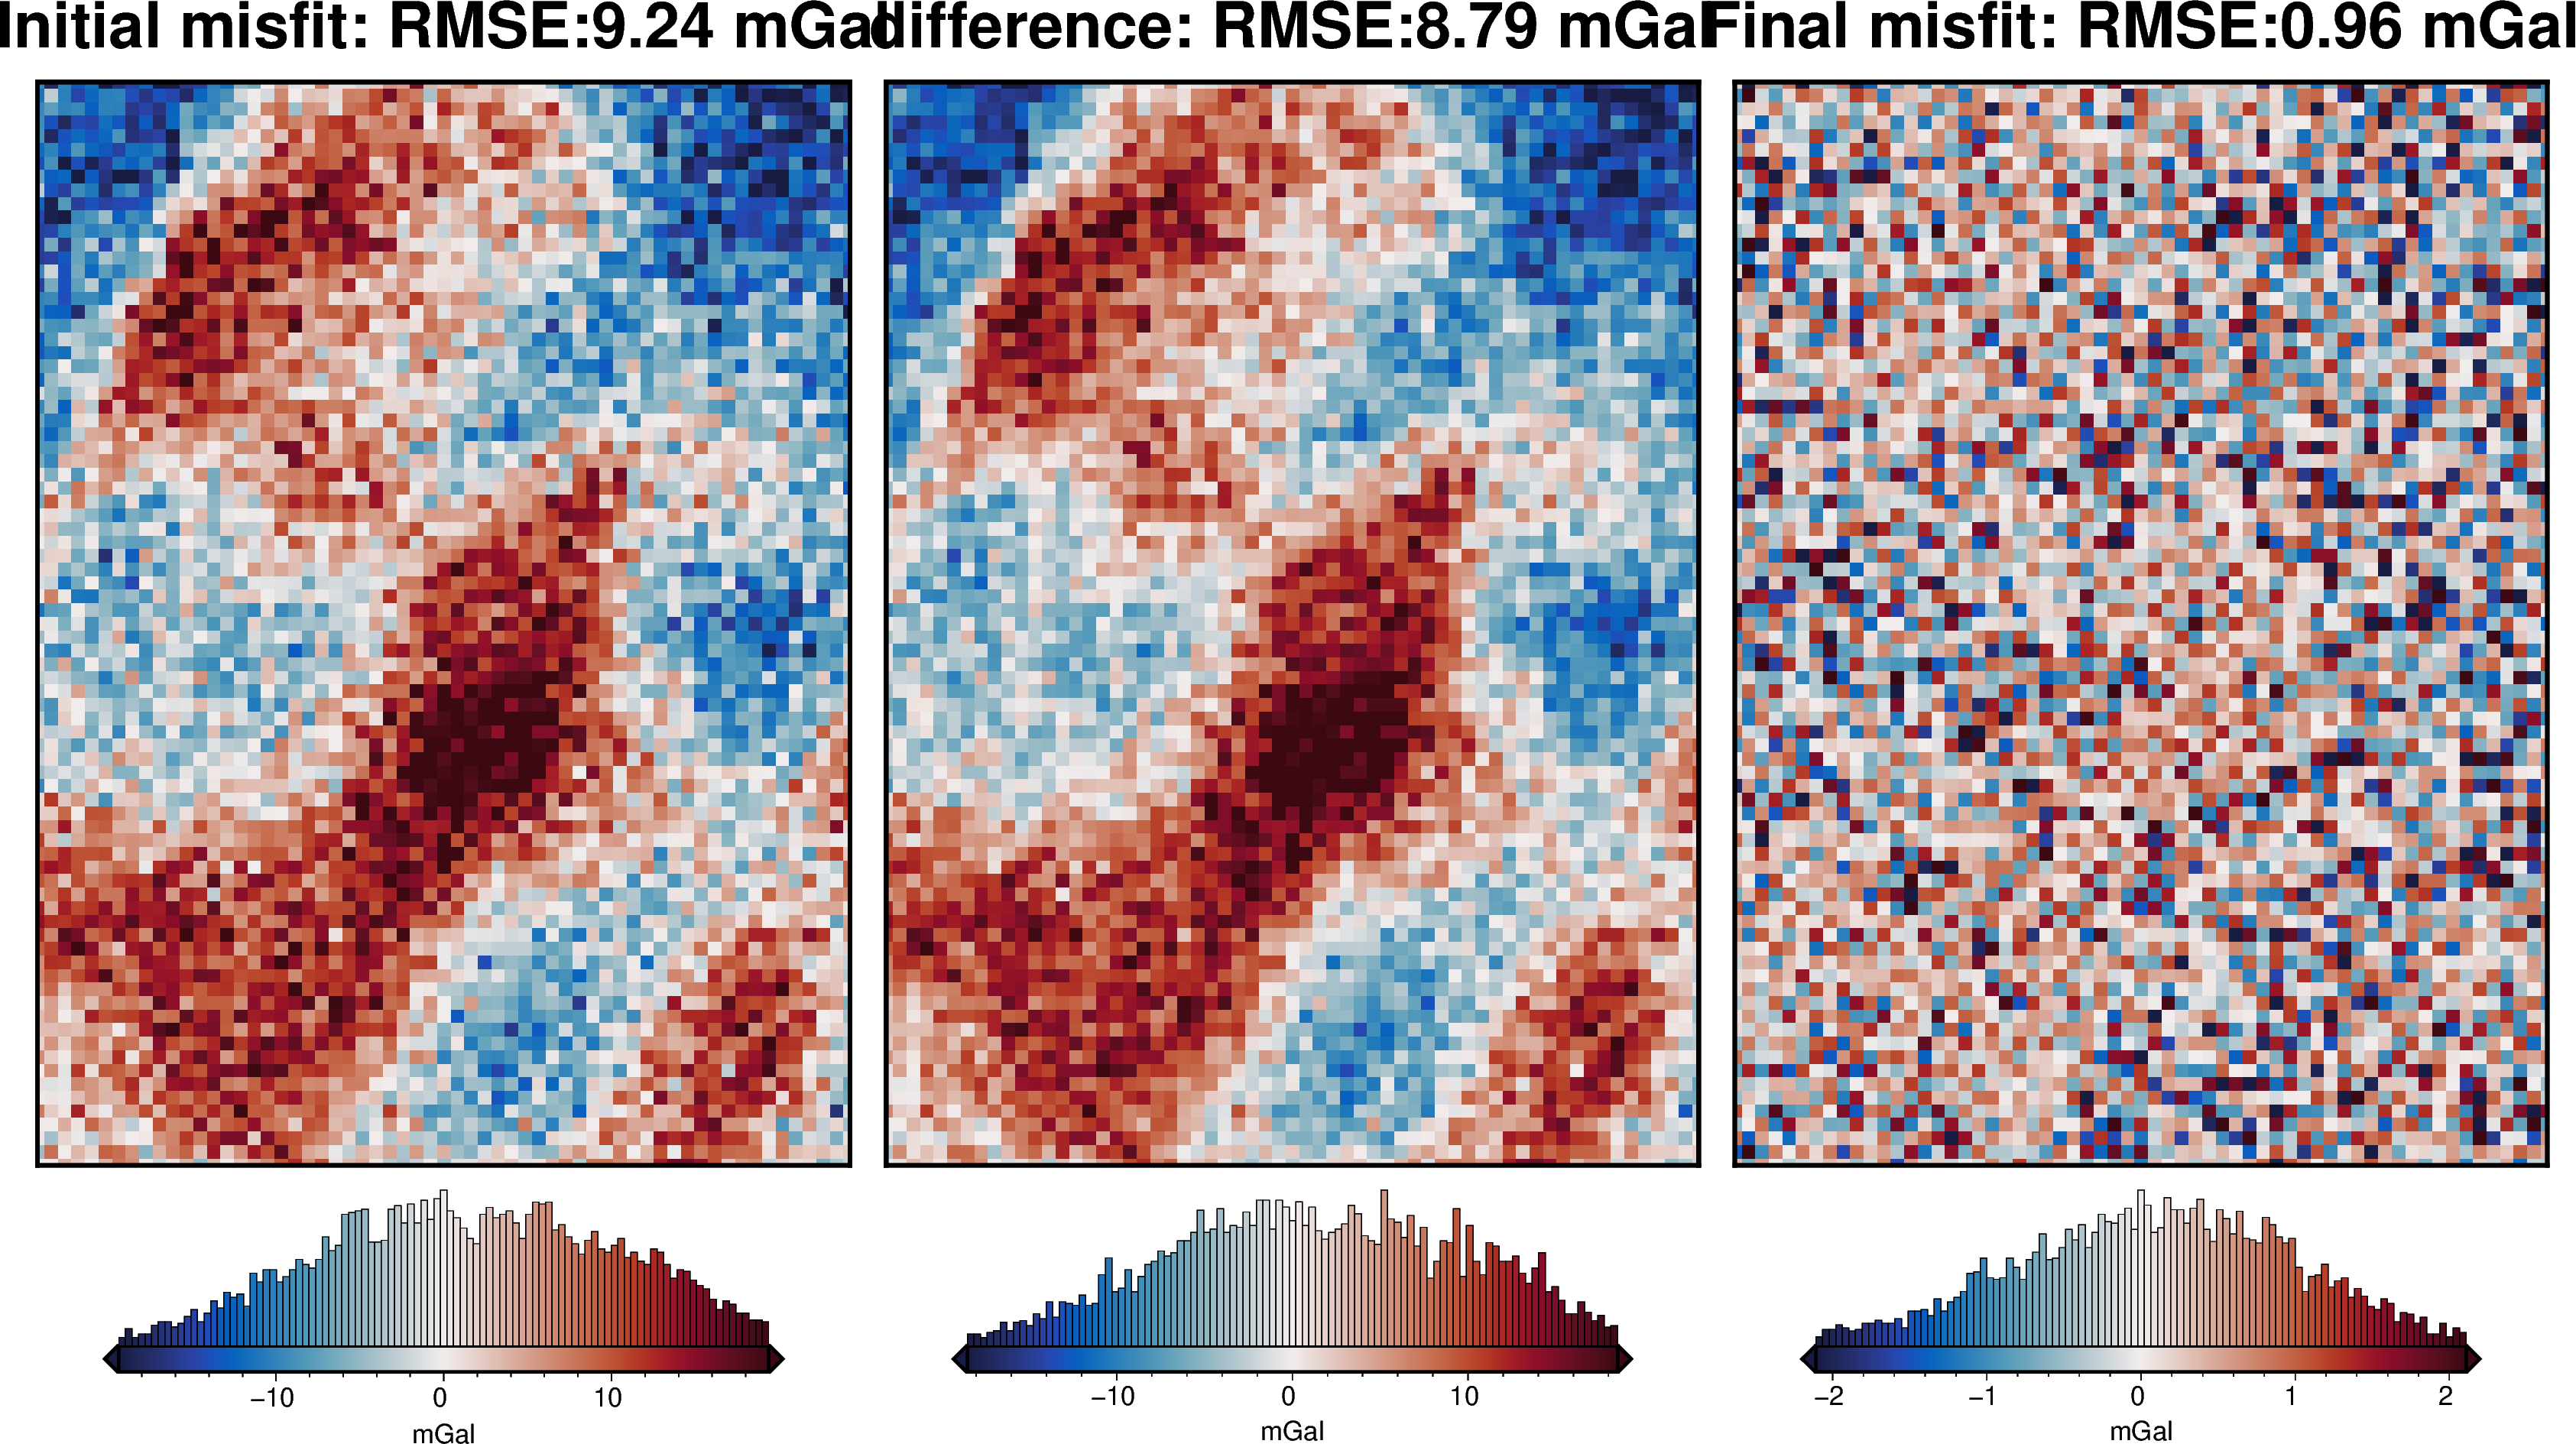

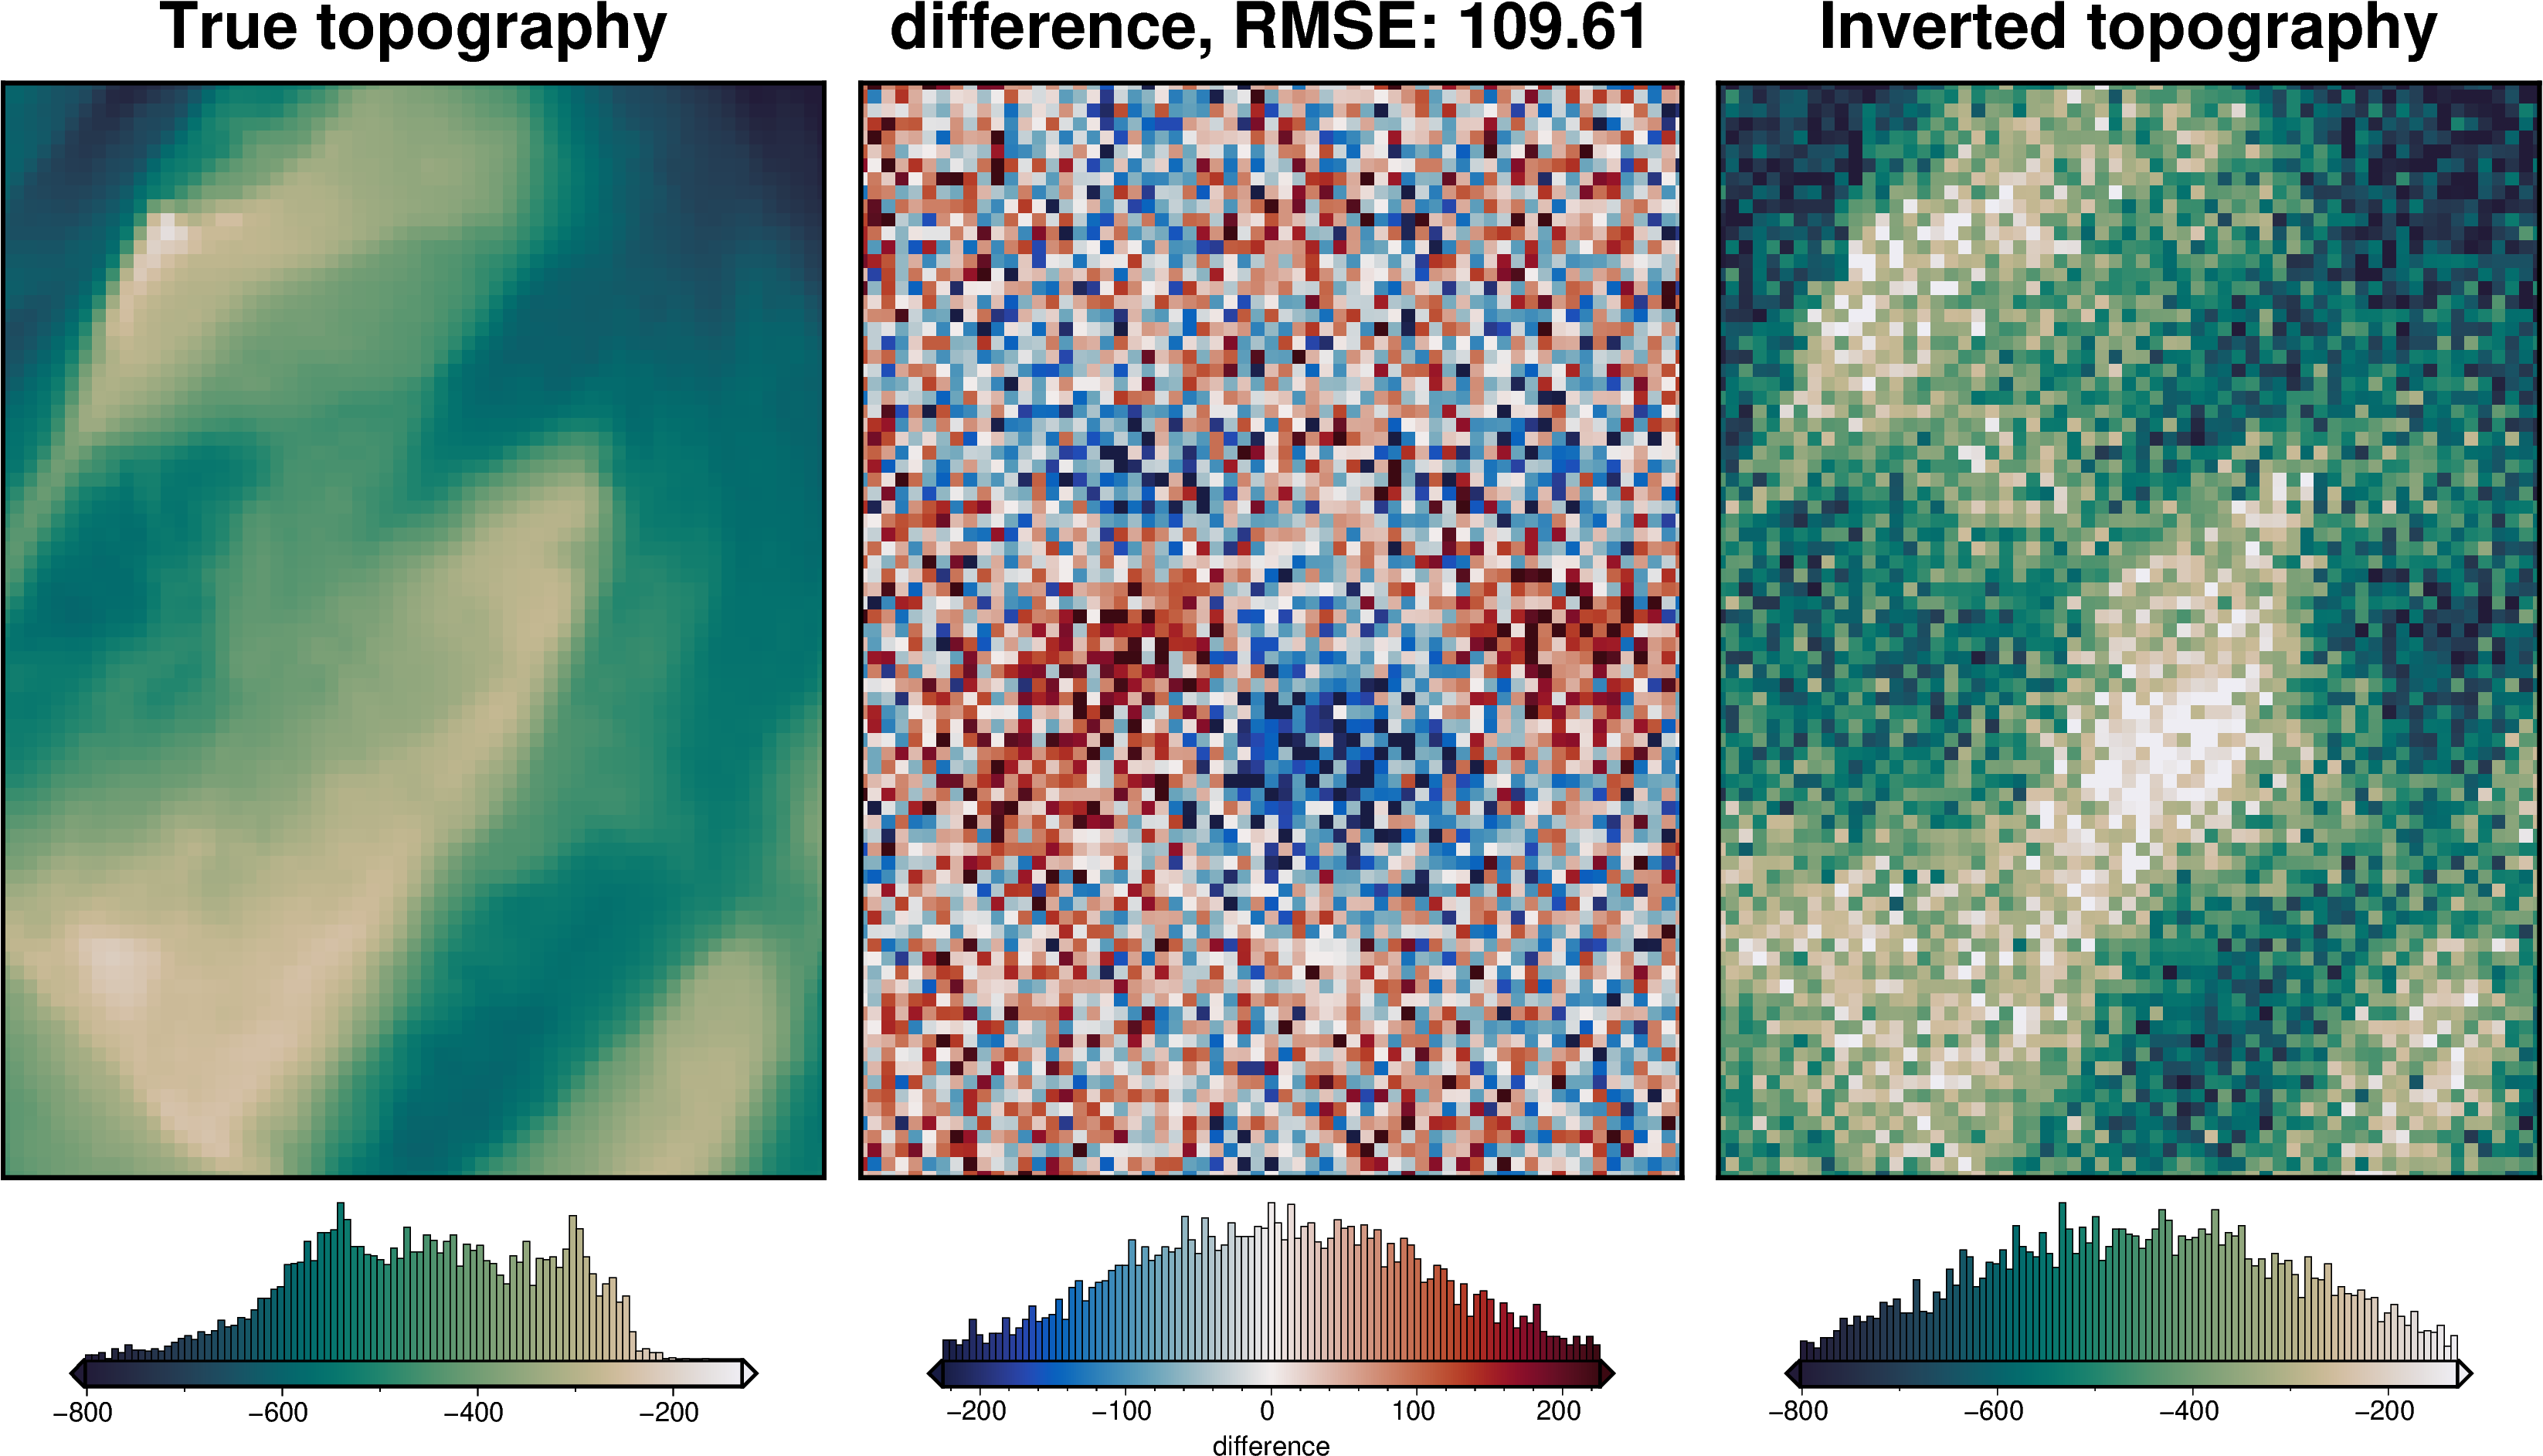

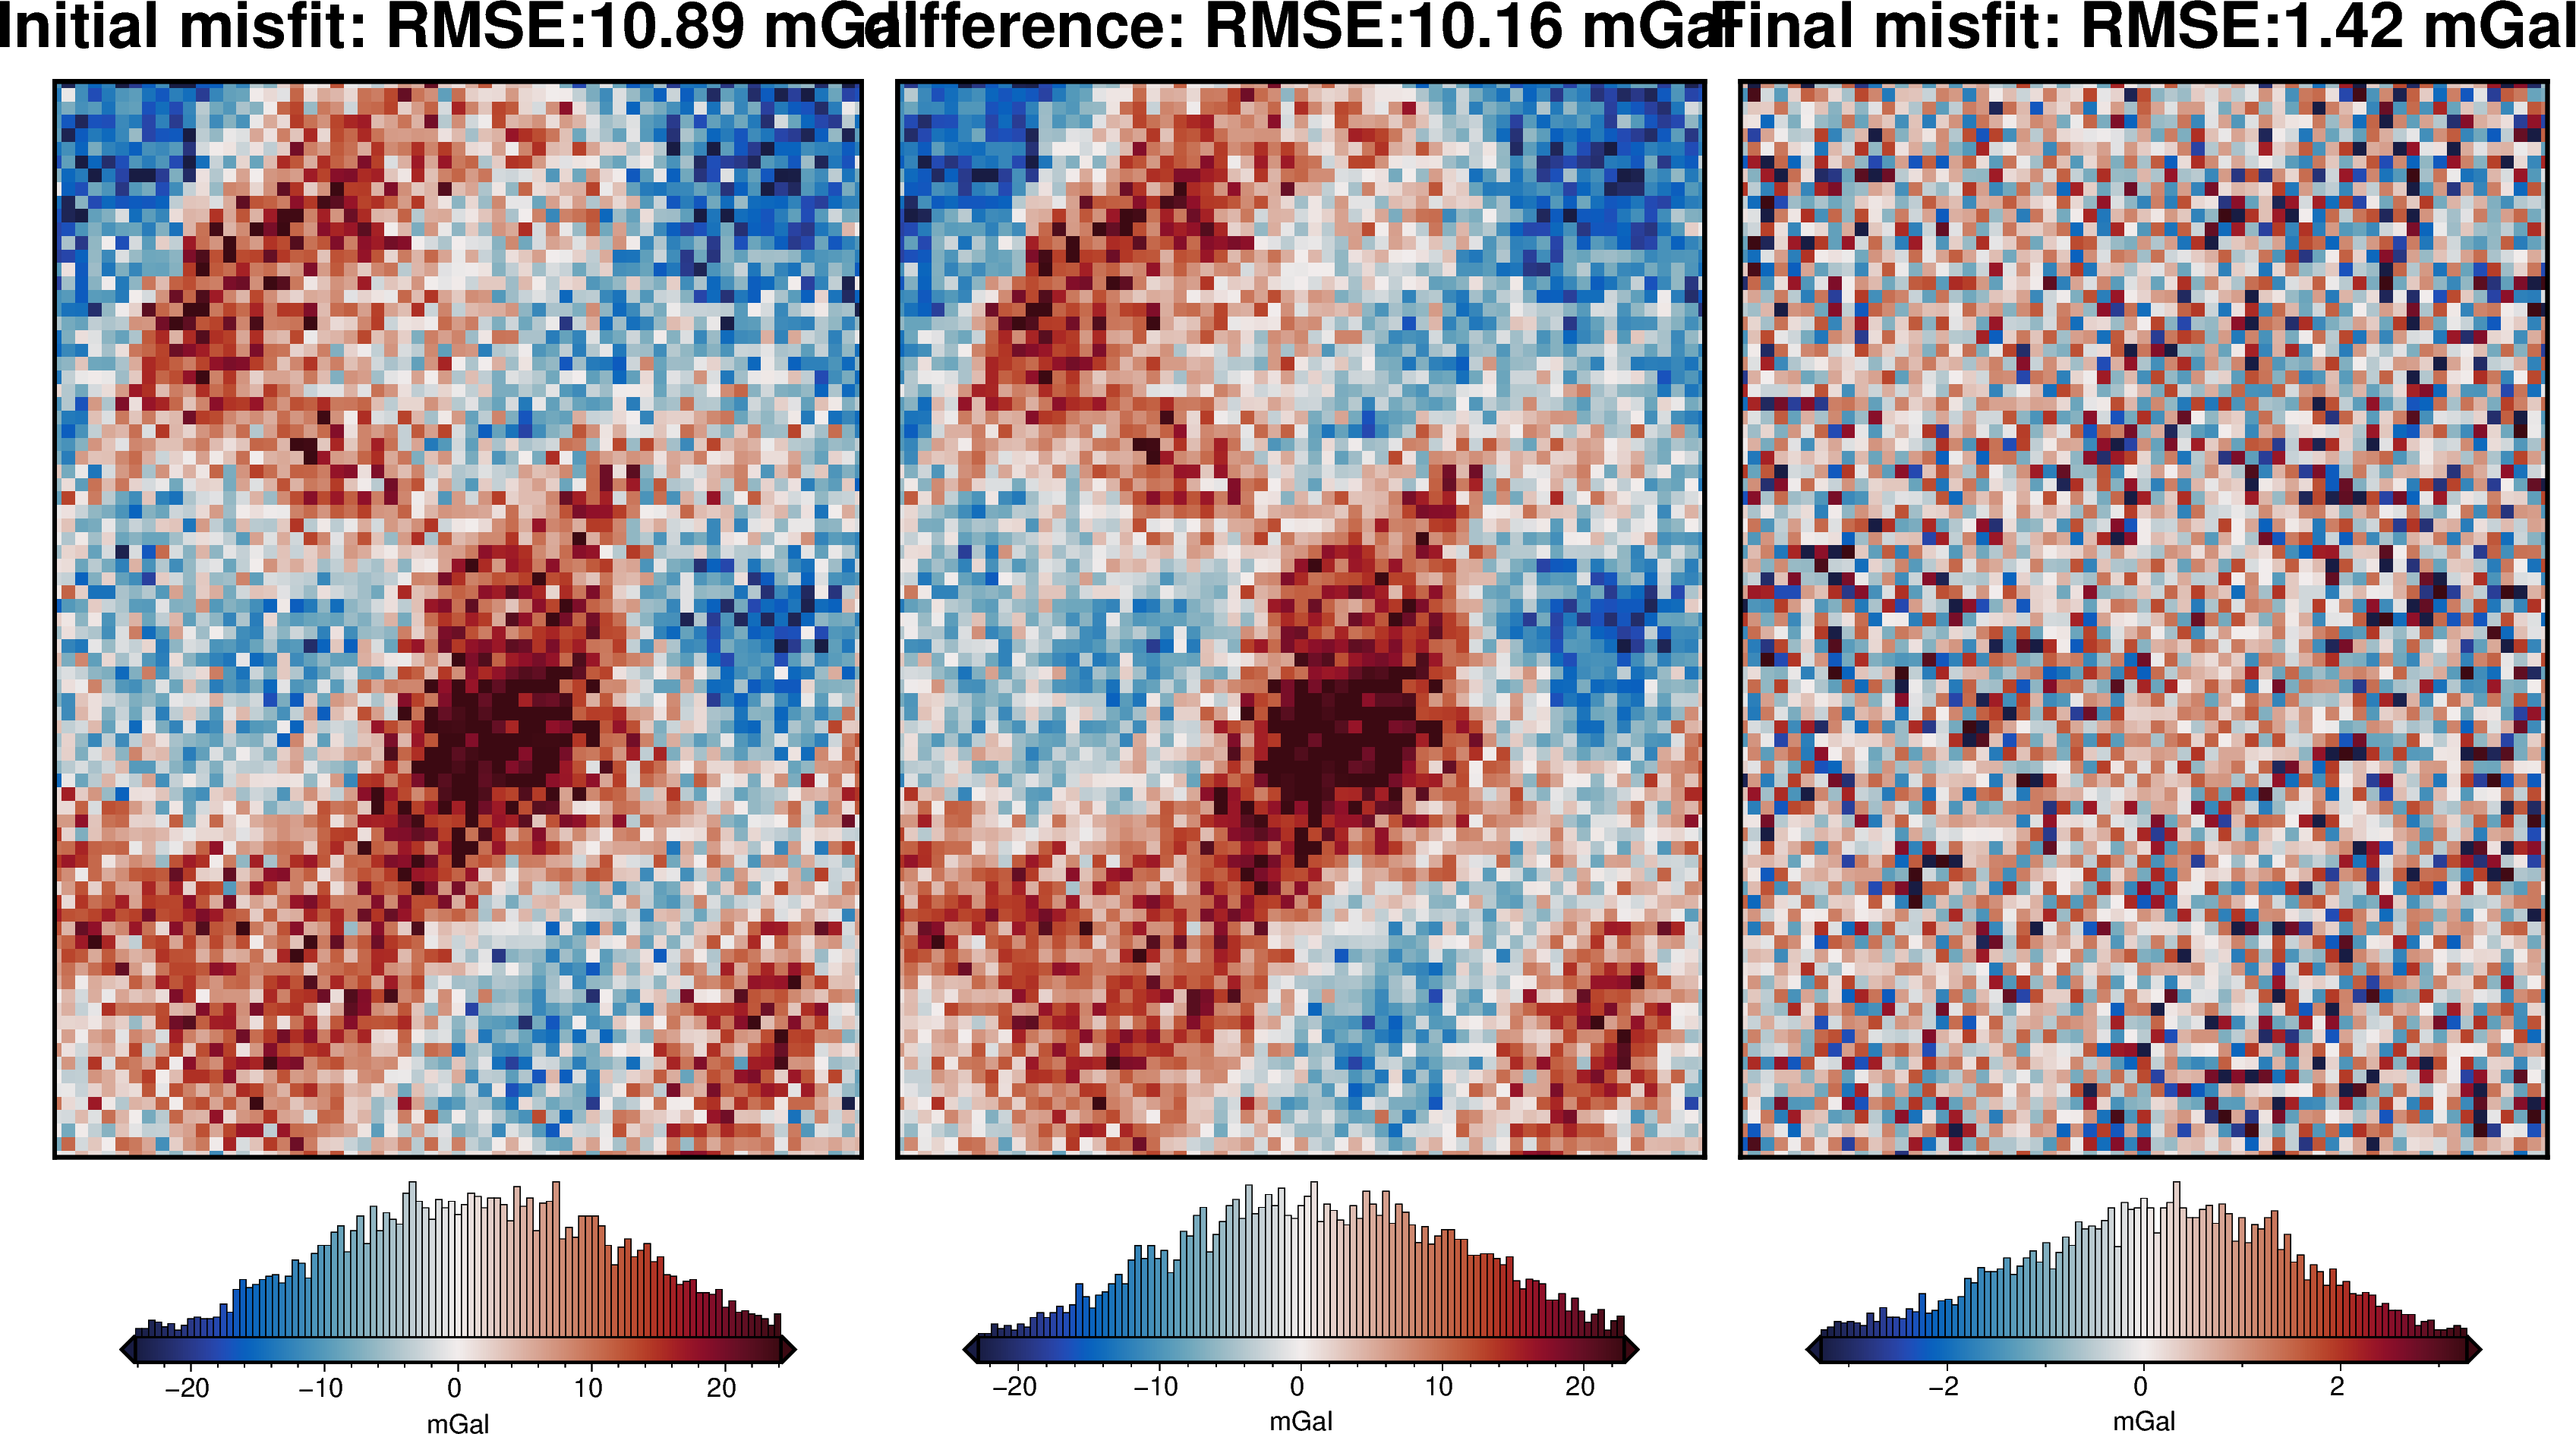

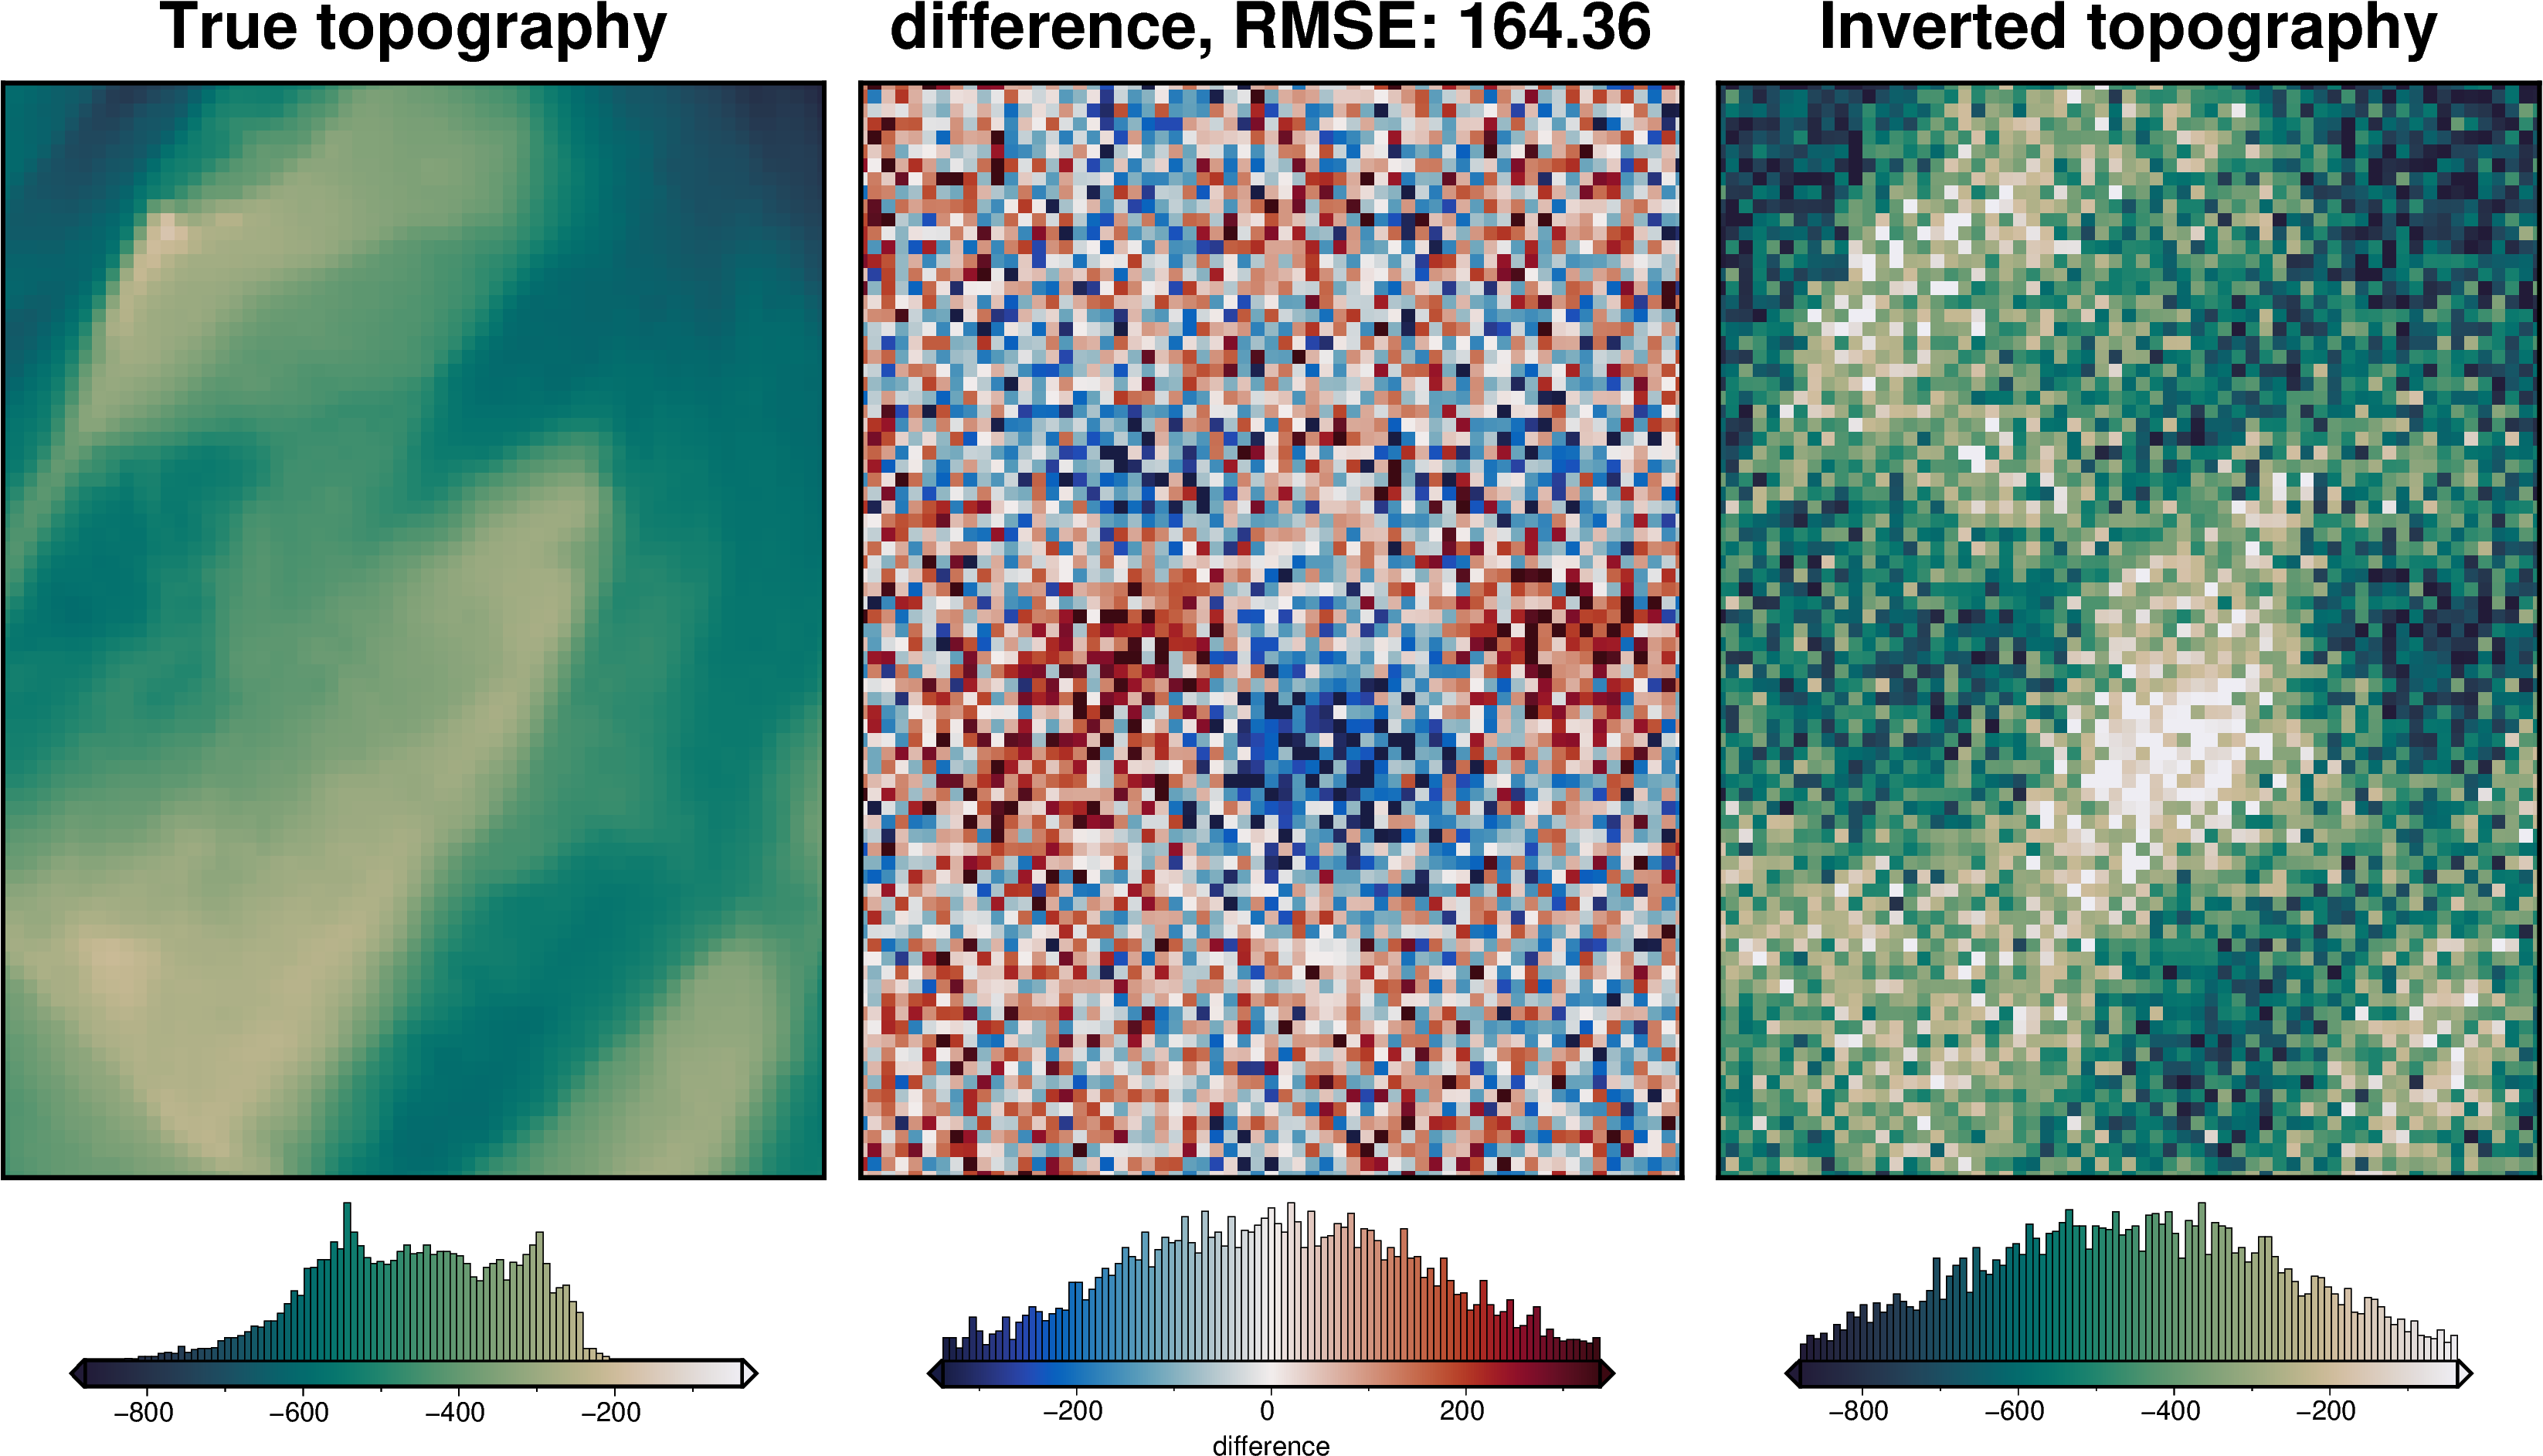

,noise,score,rmse,dampings
0,0.00,0.127745,4.515616,0.041518
1,0.67,0.210256,19.249183,0.024578
2,1.33,0.296354,36.800104,0.024578
3,2.00,0.401674,54.981524,0.024578
4,2.67,0.514177,73.254876,0.024578
5,3.33,0.628363,91.288375,0.024578
6,4.00,0.746130,109.611890,0.024578
7,4.67,0.865047,127.945360,0.024578
8,5.33,0.982955,146.011789,0.024578
9,6.00,1.103232,164.356814,0.024578


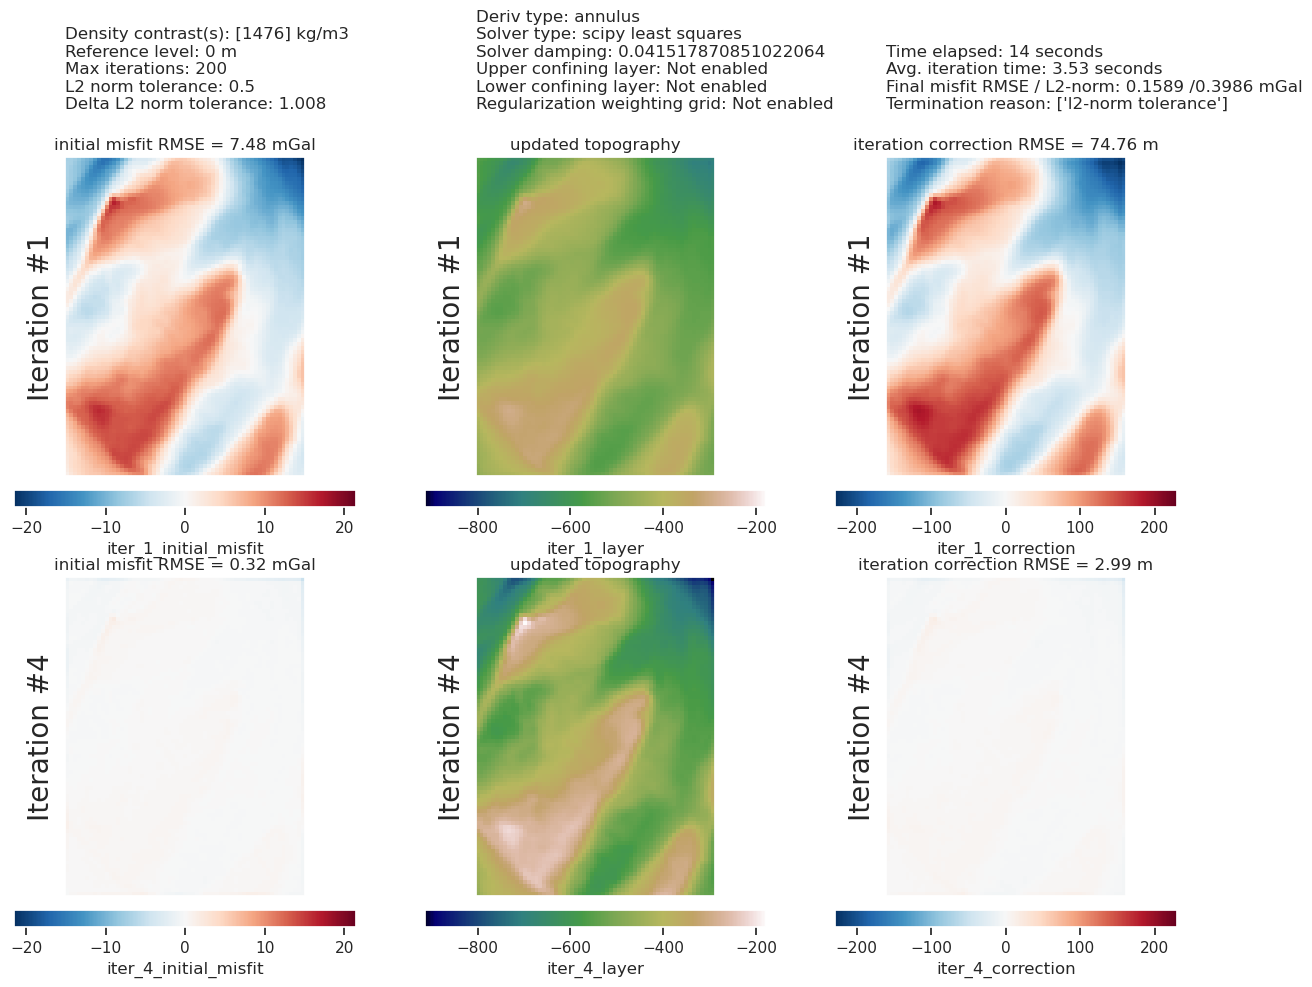

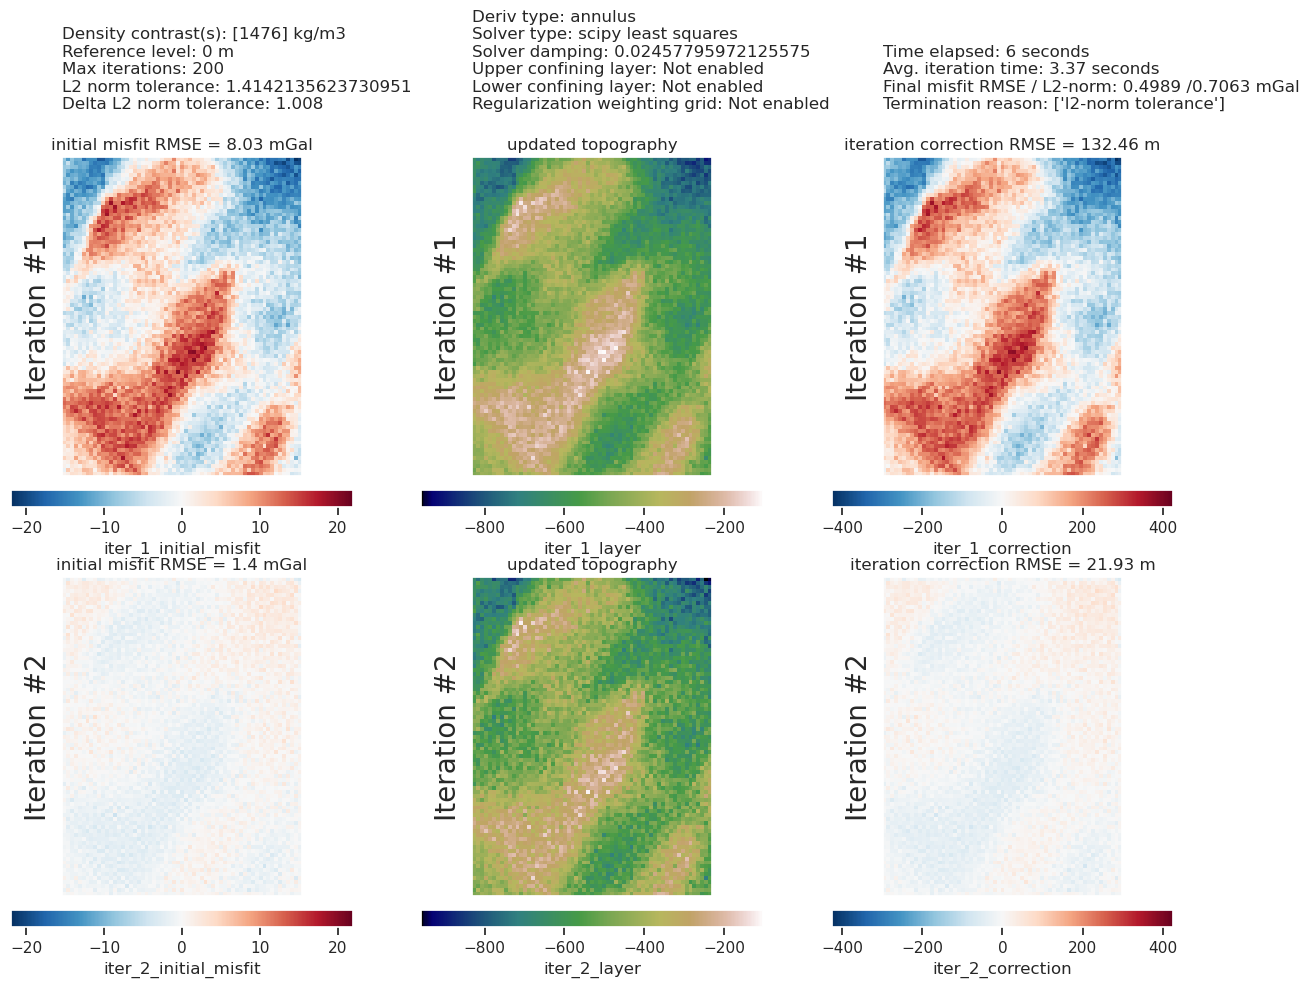

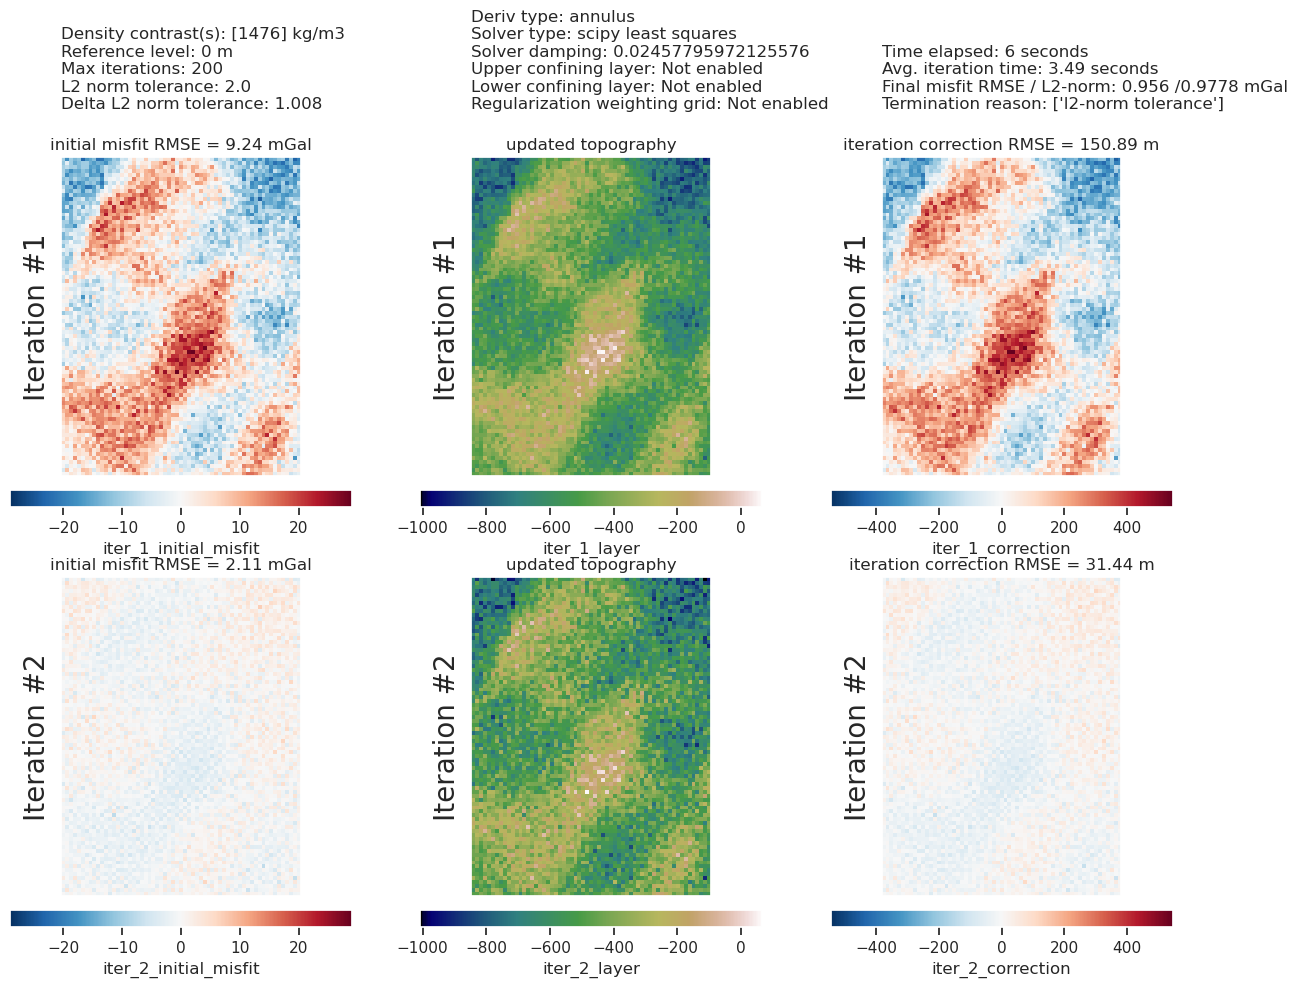

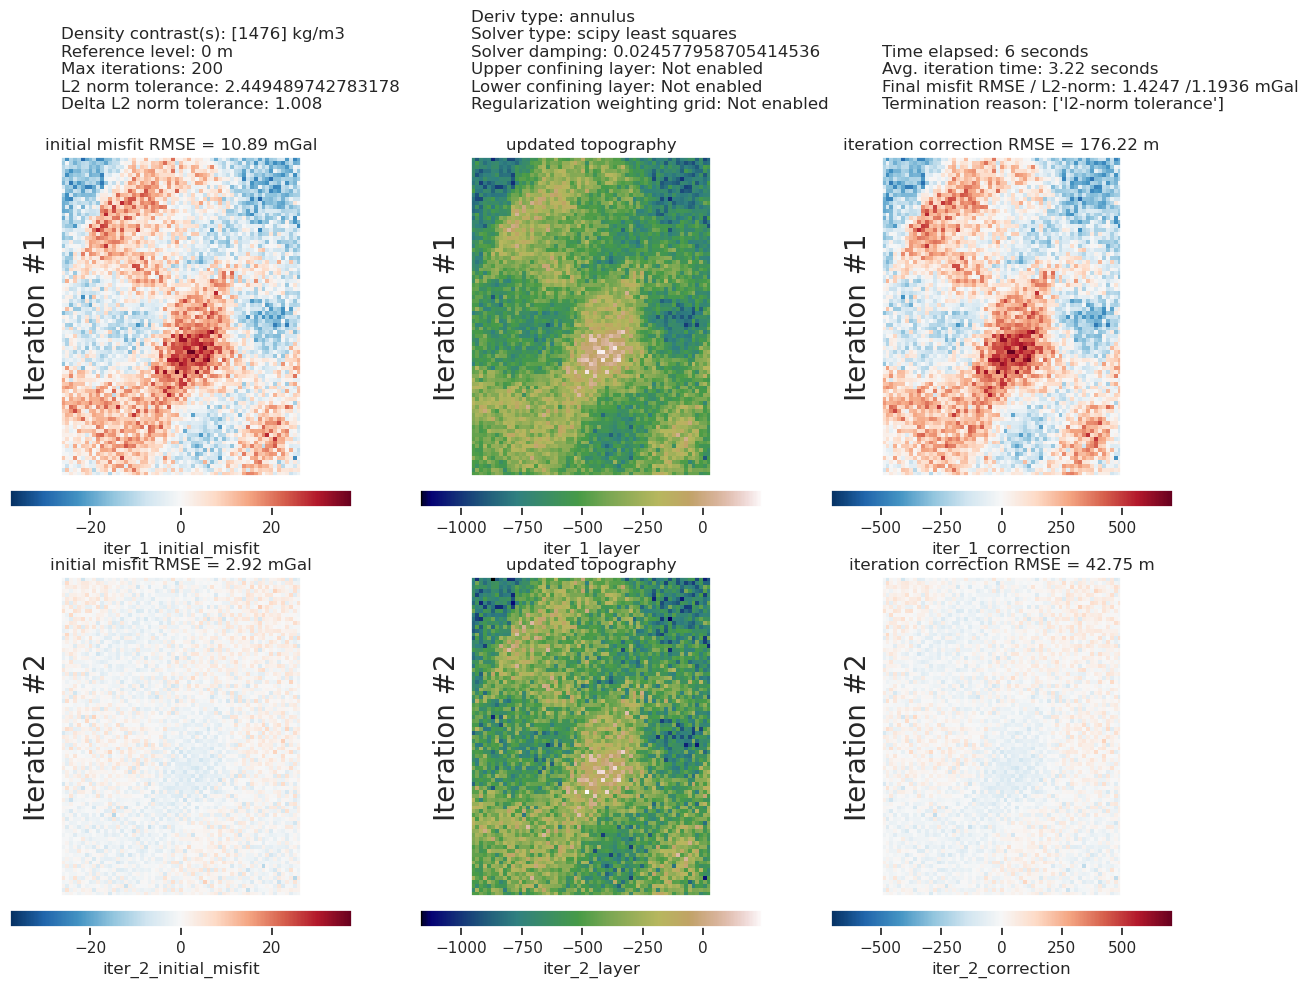

In [64]:
scores = []
rmses = []
dampings = []

for i, n in enumerate(noise_levels):
    # if i > 0:
    #     break
    fname=f"../../results/Ross_Sea_05_damping_cv_noise_{n}_mGal"

    with pathlib.Path(f"{fname}_results.pickle").open("rb") as f:
        results = pickle.load(f)

    with pathlib.Path(f"{fname}_damping_cv_study.pickle").open("rb") as f:
        study = pickle.load(f)
    dampings.append(study.best_params["damping"])
    scores.append(study.best_value)

    final_topo = results[0].set_index(["northing", "easting"]).to_xarray().topo
    inside_final_topo = final_topo.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    inside_bathy = bathymetry.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    rmse = utils.rmse(inside_final_topo-inside_bathy)
    rmses.append(rmse)

    if i % 3 == 0:
        plotting.plot_inversion_results(
            results[1],
            results[0],
            results[2],
            inversion_region,
            iters_to_plot=2,
            plot_iter_results=True,
            plot_topo_results=False,
            plot_grav_results=True,
        )
        _ = polar_utils.grd_compare(
            inside_bathy,
            inside_final_topo,
            plot=True,
            grid1_name="True topography",
            grid2_name="Inverted topography",
            robust=True,
            hist=True,
            inset=False,
            verbose="q",
            title="difference",
            grounding_line=False,
            reverse_cpt=True,
            cmap="rain",
        )

ensemble_df = pd.DataFrame(
    {
        "noise": noise_levels,
        "score": scores,
        "rmse": rmses,
        "dampings": dampings,
    }
)
ensemble_df

In [65]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    region=inversion_region,
)
starting_rmse = utils.rmse(grids[0])

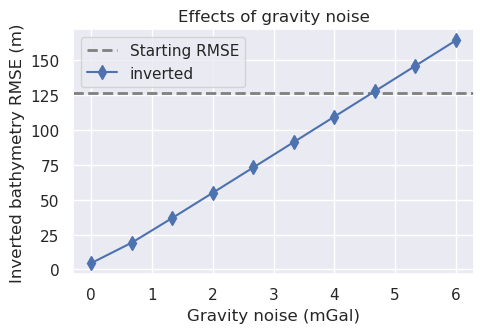

In [66]:
RIS_plotting.plot_1var_ensemble(
    df=ensemble_df,
    x="noise",
    y="rmse",
    title="Effects of gravity noise",
    xlabel="Gravity noise (mGal)",
    ylabel="Inverted bathymetry RMSE (m)",
    horizontal_line=starting_rmse,
    horizontal_line_label="Starting RMSE",
)